## TIES relative binding free energy application

Run this notebook to reproduce the Deep Active Subspace (DAS) results for the TIES application. Small variation in the results will occur due to the stochastic nature of the training procedure. Some KAS-GP are also displayed. These are loaded from file, and not directly computed here.

### Reference

Wouter Edeling, Maxime Vassaux, Yiming Yang, Shunzhou Wan, Serge Guillas, Peter Coveney, *Global ranking of the sensitivity of interaction potential contributions within classical molecular dynamics force fields*, (submitted), 2023.

### Install EasySurrogate

The Deep Active Subspace method is implemented in EasySurrogate. Uncomment to install.

In [28]:
#!pip install easysurrogate==0.24.1

In [29]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import easysurrogate as es
from scipy import linalg, stats
import pandas as pd
import json
import os
import seaborn as sns
from tqdm import tqdm

Several subroutines specific to this article are located in `../utils/utils.py`. Import this module.

In [30]:
import sys
sys.path.insert(1, '../')
from utils.utils import plot_sensitivity, plot_errors, plot_dist, early_stopping

In [31]:
%matplotlib inline
plt.rcParams['figure.dpi'] = 300

### Load input parameter values

Load the Monte Carlo values of the inputs.

In [32]:
# input parameters
params = pd.read_csv('./data_ties/ties_inputs.csv')
param_names = params.keys()
params = params.values

n_samples = params.shape[0]

# number of inputs
D = params.shape[1]

p_min = np.min(params, axis=0)
p_max = np.max(params, axis=0)

# scale inputs within [-1, 1]
params = (params - 0.5 * (p_min + p_max)) / (0.5 * (p_max - p_min))

In [33]:
print('There are %d inputs' % D)

There are 169 inputs


### Load output samples

Load the corresponding Monte Carlo outputs, in the case the relative binding free energy predictions.

In [34]:
QoI = 'relative_binding_energy'
output = pd.read_csv('./data_ties/%s_output.csv' % (QoI,)).values

### Average over the random seeds (or not)

Each parameter value was replicated several times, changing only the random seed of the initial condition.

In [35]:
average_over_replicas = True

if not average_over_replicas:
    samples = output[:, 2].reshape([-1, 1])
else:
    samples = np.mean(output, axis=1, keepdims=True)

### Select $d$

This is the dimension of the active subspace.

In [36]:
########################################
# choose the active subspace dimension #
########################################
d = 1

### Hyperparameters

In [37]:
# number of neurons per hidden layer 
n_hidden_neurons = 10
# number of hidden layer + output layer
n_layers = 4

n_neurons = [d]
for i in range(n_layers-1): n_neurons.append(n_hidden_neurons)

# activation function
activation = 'tanh'

# mini batch size
batch_size = 32
# max number of epochs
n_epochs_max = 100
# number of mini-batch iterations per epoch
n_iter = int(n_samples / batch_size)

# early stopping parameters
min_delta = 0.001
patience = 3

### Train / test split

In [38]:
test_frac = 0.1
test_idx = int((1 - test_frac) * n_samples)
params_train = params[0:test_idx, :]
samples_train = samples[0:test_idx, :]
params_test = params[test_idx:, :]
samples_test = samples[test_idx:, :]

### Select how many replica neural networks to train

To compute confidence intervals on the results (due to the stochastic nature of the training), we train `n_rep` replica networks instead of relying a single network

In [39]:
n_rep = 20

### Train a deep active subspace network



In [40]:
# results dict
results_das = {}
# eigenvalues of gradient matrix C per epoch
results_das['eigvals'] = np.zeros([n_rep, D])
# global gradient-based sensitivity indices per epoch
results_das['V_i'] = np.zeros([n_rep, D])
# relative training and test error per epoch
results_das['errors'] = []
results_das['epoch_stop'] = np.zeros(n_rep, dtype=int)
results_das['projection_matrix'] = []
results_das['surrogate'] = []
results_das['C_das'] = []

In [41]:
def train_das(failure_criterion = 1.0):
    """
    Train DAS networks using early stopping.
    
    failure_criterion : float
        Most replica networks will converge, a small number might not. 
        failure_critertion is the value of the relative test error
        used to determine if a network did not converge. If exceeded
        the network will be discarded. Default value is 1.0 (100% test error).

    """
    min_test_error = 1.0

    # repeat analysis n_rep times to generate error bars on results
    for rep in range(n_rep):

        # train remaining epochs through early stopping
        final_test_error = 2.0
        while final_test_error > failure_criterion:
        
            # create new DAS network and train for 1 epoch
            das_surrogate = es.methods.DAS_Surrogate()
            das_surrogate.train(params_train, samples_train, d, 
                                n_iter=n_iter,
                                n_layers=n_layers,
                                n_neurons=n_hidden_neurons, 
                                activation=activation, 
                                batch_size=batch_size,
                                standardize_X=False, standardize_y=True)

            # train remaining epochs through early stopping
            errors, epoch = early_stopping(das_surrogate, n_iter,
                                           params_train, samples_train, 
                                           params_test, samples_test)
            final_test_error = errors[epoch, 1]

        results_das['errors'].append(errors)
        results_das['epoch_stop'][rep] = epoch

        ### Compute active subspace of the DAS network

        # the gradient matrix computed of the DAS network, computed using the classical AS method
        C_das = 0.0

        # Number of Monte Carlo samples
        n_mc = params.shape[0]    

        # Compute C_das, the gradient matrix of the DAS network
        das_samples = np.zeros(n_mc)
        for i, param in enumerate(params):
            # compute the derivative of f at the input layer (needed for C_das)
            df_dx = das_surrogate.derivative(param, norm=False)
            # update C_das
            C_das += np.dot(df_dx, df_dx.T) / n_mc

        results_das['C_das'].append(C_das)
            
        # solve eigenvalue problem for C_das
        eigvals_C_das, eigvecs_C_das = linalg.eigh(C_das)

        # Sort the eigensolutions in the descending order of eigenvalues
        order = eigvals_C_das.argsort()[::-1]
        eigvals_C_das = eigvals_C_das[order]
        eigvecs_C_das = eigvecs_C_das[:, order]

        # store eigenvalues of this iteration
        results_das['eigvals'][rep] = eigvals_C_das

        # the DAS weight matrix of the first hidden layer
        W_1 = das_surrogate.neural_net.layers[1].W
        results_das['projection_matrix'].append(W_1)
        # The dominant eigenvector(s) from the C_das matrix (alternative to W_1)
        # results_das['projection_matrix'].append(eigvecs_C_das[:, 0:d])

        # perform sensitivity analysis using combined training and test data 
        das_analysis = es.analysis.DAS_analysis(das_surrogate)
        idx, V_i = das_analysis.sensitivity_measures(params, norm=False)
        results_das['V_i'][rep] = V_i.flatten() #* das_surrogate.neural_net.y_std ** 2

        # store surrogate
        results_das['surrogate'].append(das_surrogate)


Train `n_rep` DAS surrogate. A converged DAS network will have a test error well below 40%, set `failure_criterion=0.5`.

In [42]:
train_das(failure_criterion=0.5)

Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.3690


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 277.15it/s]

Relative training error = 64.1199 %


Relative test error = 62.8386 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.59it/s]

 loss = 0.8944


Relative training error = 59.1170 %
Relative test error = 60.7380 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 323.27it/s]

 loss = 1.1219


Relative training error = 51.8256 %
Relative test error = 59.9546 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 295.60it/s]

 loss = 1.1851


Relative training error = 44.4617 %
Relative test error = 58.5703 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.80it/s]

 loss = 0.1910


Relative training error = 38.3682 %
Relative test error = 56.9442 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 281.91it/s]

 loss = 0.3046


Relative training error = 34.3589 %
Relative test error = 52.9243 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 308.91it/s]

 loss = 0.3898


Relative training error = 31.3392 %
Relative test error = 47.8461 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 325.83it/s]

 loss = 0.1502


Relative training error = 29.7869 %
Relative test error = 43.6145 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 267.16it/s]

 loss = 0.2118


Relative training error = 28.3233 %
Relative test error = 41.3081 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1291


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 253.28it/s]


Relative training error = 27.5748 %
Relative test error = 40.3796 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3796


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 273.08it/s]


Relative training error = 26.2548 %
Relative test error = 38.5936 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0880


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 278.82it/s]


Relative training error = 25.4018 %
Relative test error = 35.8732 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.57it/s]

 loss = 0.3231


Relative training error = 24.4310 %
Relative test error = 34.6584 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.94it/s]


 loss = 0.0962
Relative training error = 23.9113 %
Relative test error = 34.3390 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0549


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 293.67it/s]


Relative training error = 23.3541 %
Relative test error = 34.0574 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.40it/s]


 loss = 0.1105
Relative training error = 22.6274 %
Relative test error = 33.6415 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.98it/s]


 loss = 0.0993
Relative training error = 22.0776 %
Relative test error = 33.5716 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0887


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 271.66it/s]


Relative training error = 21.7360 %
Relative test error = 33.3728 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.69it/s]


 loss = 0.0882
Relative training error = 21.2964 %
Relative test error = 32.3044 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.55it/s]

 loss = 0.1615
Relative training error = 21.2033 %
Relative test error = 32.6579 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.61it/s]

 loss = 0.2185
Relative training error = 21.0819 %
Relative test error = 32.5896 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.21it/s]


 loss = 0.1027
Relative training error = 20.5208 %
Relative test error = 32.6767 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.04it/s]


Relative training error = 20.2714 %
Relative test error = 32.6154 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.45it/s]


 loss = 1.0509
Relative training error = 62.7291 %
Relative test error = 61.0368 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 447.74it/s]

 loss = 0.8233
Relative training error = 61.3026 %


Relative test error = 61.2174 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.76it/s]


 loss = 2.5013
Relative training error = 59.6311 %
Relative test error = 60.8234 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 274.75it/s]

 loss = 1.1322


Relative training error = 58.7281 %
Relative test error = 62.1161 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5560


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.36it/s]


Relative training error = 57.1181 %
Relative test error = 60.1339 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.92it/s]

 loss = 0.3623


Relative training error = 56.2047 %
Relative test error = 60.7917 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 343.47it/s]

 loss = 0.3569


Relative training error = 55.3685 %
Relative test error = 60.5630 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.90it/s]

 loss = 0.4858


Relative training error = 54.4444 %
Relative test error = 61.8590 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.14it/s]

 loss = 0.6357


Relative training error = 53.1426 %
Relative test error = 61.3815 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 246.29it/s]

 loss = 0.8974


Relative training error = 52.3552 %
Relative test error = 60.5345 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 298.77it/s]

 loss = 0.5190


Relative training error = 51.3044 %
Relative test error = 61.2194 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.50it/s]

 loss = 1.0903


Relative training error = 50.7170 %
Relative test error = 61.8738 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.71it/s]

 loss = 0.7234


Relative training error = 50.6965 %
Relative test error = 63.8749 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 342.74it/s]

 loss = 0.4330
Relative training error = 49.7753 %


Relative test error = 63.5654 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.90it/s]

 loss = 0.5858
Relative training error = 59.3424 %


Relative test error = 58.9892 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.39it/s]

 loss = 1.3428
Relative training error = 50.6749 %


Relative test error = 59.2630 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.50it/s]


 loss = 0.8709
Relative training error = 42.9014 %
Relative test error = 59.1531 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.58it/s]


 loss = 0.4736
Relative training error = 38.2913 %
Relative test error = 53.3917 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.36it/s]


 loss = 0.4577
Relative training error = 34.5222 %
Relative test error = 47.7501 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.28it/s]


 loss = 0.1524
Relative training error = 32.0259 %
Relative test error = 44.8798 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1841


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.49it/s]


Relative training error = 30.1756 %
Relative test error = 42.7910 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4471


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.90it/s]


Relative training error = 28.8793 %
Relative test error = 40.1860 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.86it/s]


 loss = 0.2281
Relative training error = 27.5938 %
Relative test error = 39.4540 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.53it/s]

 loss = 0.1476
Relative training error = 26.4066 %
Relative test error = 40.2452 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.87it/s]

 loss = 0.1424


Relative training error = 25.2583 %
Relative test error = 38.1863 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.20it/s]


 loss = 0.0937
Relative training error = 24.4881 %
Relative test error = 38.0976 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.32it/s]


 loss = 0.1817
Relative training error = 23.9111 %
Relative test error = 37.7079 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.27it/s]


 loss = 0.0851
Relative training error = 23.4627 %
Relative test error = 37.0187 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 295.28it/s]

 loss = 0.0682


Relative training error = 22.7535 %
Relative test error = 35.4356 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 333.51it/s]

 loss = 0.2065


Relative training error = 22.3821 %
Relative test error = 33.6638 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 284.65it/s]

 loss = 0.2292


Relative training error = 21.8440 %
Relative test error = 33.3566 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 333.64it/s]

 loss = 0.1889


Relative training error = 21.6048 %
Relative test error = 32.9814 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.59it/s]

 loss = 0.0714


Relative training error = 21.3476 %
Relative test error = 31.8500 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 316.64it/s]

 loss = 0.2042


Relative training error = 21.0618 %
Relative test error = 31.3433 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.83it/s]

 loss = 0.0658


Relative training error = 20.7521 %
Relative test error = 32.3590 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.65it/s]

 loss = 0.0648


Relative training error = 20.3425 %
Relative test error = 32.3814 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 318.39it/s]

 loss = 0.0643


Relative training error = 19.7158 %
Relative test error = 33.0698 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.08it/s]

 loss = 0.1552


Relative training error = 19.5071 %
Relative test error = 32.5057 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.46it/s]


 loss = 1.2694
Relative training error = 64.8720 %
Relative test error = 63.0562 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.61it/s]

 loss = 0.6308


Relative training error = 63.7311 %
Relative test error = 61.0785 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.43it/s]


 loss = 0.6742
Relative training error = 62.7808 %
Relative test error = 61.1459 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 296.27it/s]

 loss = 0.6367


Relative training error = 61.6384 %
Relative test error = 60.8848 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.78it/s]


 loss = 1.4746
Relative training error = 59.8860 %
Relative test error = 62.5053 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.76it/s]

 loss = 1.2478


Relative training error = 57.4938 %
Relative test error = 63.8479 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.17it/s]

 loss = 0.2895


Relative training error = 55.5853 %
Relative test error = 63.4011 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 319.93it/s]

 loss = 0.6532


Relative training error = 53.6437 %
Relative test error = 63.0259 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.35it/s]

 loss = 0.4058


Relative training error = 51.3319 %
Relative test error = 63.9557 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 312.21it/s]

 loss = 1.0687


Relative training error = 49.8575 %
Relative test error = 63.2405 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.50it/s]

 loss = 0.6930


Relative training error = 48.6045 %
Relative test error = 62.6523 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.16it/s]

 loss = 0.5134
Relative training error = 47.5231 %
Relative test error = 60.9907 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.78it/s]


 loss = 0.8539
Relative training error = 46.4831 %
Relative test error = 59.3622 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.59it/s]


 loss = 0.8991
Relative training error = 45.9280 %
Relative test error = 59.6570 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.23it/s]

 loss = 0.8734


Relative training error = 45.5019 %
Relative test error = 60.3324 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.28it/s]


 loss = 0.6290
Relative training error = 44.9142 %
Relative test error = 59.7998 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.57it/s]

 loss = 0.0866
Relative training error = 44.1353 %


Relative test error = 59.2847 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.89it/s]


 loss = 0.2490
Relative training error = 43.3800 %
Relative test error = 59.1729 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0902


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.94it/s]


Relative training error = 42.9821 %
Relative test error = 60.9300 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4773


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.69it/s]


Relative training error = 42.4878 %
Relative test error = 60.5031 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.32it/s]


Relative training error = 41.6719 %
Relative test error = 59.0137 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.31it/s]


 loss = 0.1078
Relative training error = 41.3709 %
Relative test error = 59.3419 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.17it/s]


 loss = 0.2593
Relative training error = 41.0892 %
Relative test error = 59.3746 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2063


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.12it/s]


Relative training error = 40.9396 %
Relative test error = 59.0188 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5765


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.83it/s]


Relative training error = 40.4172 %
Relative test error = 60.4805 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.70it/s]


 loss = 0.6700
Relative training error = 39.8860 %
Relative test error = 62.4941 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3160


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 267.11it/s]


Relative training error = 39.4859 %
Relative test error = 64.2168 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 301.10it/s]

 loss = 0.3831


Relative training error = 38.9129 %
Relative test error = 63.5671 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.87it/s]

 loss = 0.6672


Relative training error = 63.2376 %
Relative test error = 60.6137 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.92it/s]

 loss = 0.4408


Relative training error = 62.6881 %
Relative test error = 61.4923 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 347.85it/s]

 loss = 0.9481


Relative training error = 61.9110 %
Relative test error = 62.7976 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.13it/s]

 loss = 0.5755


Relative training error = 60.8544 %
Relative test error = 63.7819 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 203.17it/s]

 loss = 1.2478


Relative training error = 59.8184 %
Relative test error = 64.1631 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 2.4112


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 183.25it/s]


Relative training error = 62.2924 %
Relative test error = 63.9517 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4576


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 240.42it/s]


Relative training error = 57.5845 %
Relative test error = 64.2002 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6093


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 253.69it/s]


Relative training error = 51.8553 %
Relative test error = 64.8368 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 265.73it/s]

 loss = 0.6836


Relative training error = 47.0318 %
Relative test error = 69.6586 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.69it/s]

 loss = 0.5229


Relative training error = 42.1552 %
Relative test error = 64.8781 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.40it/s]

 loss = 0.8783


Relative training error = 63.5384 %
Relative test error = 59.7487 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 268.97it/s]

 loss = 0.6125


Relative training error = 57.5419 %
Relative test error = 56.5077 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.91it/s]

 loss = 0.4141


Relative training error = 52.0164 %
Relative test error = 58.1826 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 309.13it/s]

 loss = 0.4207


Relative training error = 45.7739 %
Relative test error = 52.2956 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 308.04it/s]


Relative training error = 39.6032 %
Relative test error = 51.9514 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2967


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.72it/s]


Relative training error = 35.5760 %
Relative test error = 44.1913 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 301.19it/s]


 loss = 0.1446
Relative training error = 34.0835 %
Relative test error = 40.3796 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2523


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 293.37it/s]


Relative training error = 31.5306 %
Relative test error = 38.1302 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1214


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 279.14it/s]


Relative training error = 29.7024 %
Relative test error = 36.6947 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 336.37it/s]

 loss = 0.1044


Relative training error = 28.2762 %
Relative test error = 34.1276 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 317.47it/s]

 loss = 0.1600


Relative training error = 27.3633 %
Relative test error = 31.8825 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 304.99it/s]

 loss = 0.0966


Relative training error = 26.8037 %
Relative test error = 29.9009 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.23it/s]

 loss = 0.0957


Relative training error = 26.1785 %
Relative test error = 29.0925 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.12it/s]


 loss = 0.0605
Relative training error = 25.3686 %
Relative test error = 29.4781 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.09it/s]

 loss = 0.1184


Relative training error = 24.4012 %
Relative test error = 27.5121 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.43it/s]


 loss = 0.1426
Relative training error = 24.3539 %
Relative test error = 27.9812 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0679


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.71it/s]


Relative training error = 23.4948 %
Relative test error = 28.3276 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1152


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.68it/s]


Relative training error = 23.3213 %
Relative test error = 28.1310 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1468


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.41it/s]


Relative training error = 23.1652 %
Relative test error = 29.1402 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0979


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.46it/s]


Relative training error = 22.5175 %
Relative test error = 28.4098 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0670


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.41it/s]


Relative training error = 22.1437 %
Relative test error = 28.2695 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0901


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.36it/s]


Relative training error = 21.8210 %
Relative test error = 28.0477 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.09it/s]

 loss = 0.0520


Relative training error = 21.3477 %
Relative test error = 28.0135 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 313.51it/s]

 loss = 0.2479


Relative training error = 20.9024 %
Relative test error = 27.8064 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.43it/s]

 loss = 0.0520


Relative training error = 20.5830 %
Relative test error = 28.1361 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.48it/s]

 loss = 0.1025


Relative training error = 20.2591 %
Relative test error = 28.4375 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 289.24it/s]

 loss = 0.0536


Relative training error = 20.1600 %
Relative test error = 29.4526 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 302.08it/s]

 loss = 0.0726


Relative training error = 19.8676 %
Relative test error = 29.8659 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.51it/s]


 loss = 0.9306
Relative training error = 62.1229 %
Relative test error = 58.1012 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4420


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.70it/s]


Relative training error = 57.5821 %
Relative test error = 53.8944 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.72it/s]


Relative training error = 51.4551 %
Relative test error = 51.1720 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0429


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.54it/s]


Relative training error = 44.4644 %
Relative test error = 51.1754 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8666


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.56it/s]


Relative training error = 39.5917 %
Relative test error = 49.7074 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4588


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 328.68it/s]


Relative training error = 37.0625 %
Relative test error = 47.5272 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.63it/s]

 loss = 0.6050


Relative training error = 33.8996 %
Relative test error = 46.4804 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.91it/s]

 loss = 0.1522


Relative training error = 32.0972 %
Relative test error = 44.0687 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 298.14it/s]

 loss = 0.1001


Relative training error = 30.5309 %
Relative test error = 40.4271 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 446.60it/s]

 loss = 0.1525


Relative training error = 29.6841 %
Relative test error = 37.9252 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.95it/s]


 loss = 0.1194
Relative training error = 28.5779 %
Relative test error = 36.6479 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1324


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.31it/s]


Relative training error = 28.2036 %
Relative test error = 35.8614 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1315


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.71it/s]


Relative training error = 27.2163 %
Relative test error = 35.0053 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.53it/s]

 loss = 0.0824


Relative training error = 26.5197 %
Relative test error = 33.7359 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.76it/s]

 loss = 0.0811


Relative training error = 25.6410 %
Relative test error = 33.0916 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.64it/s]

 loss = 0.0575


Relative training error = 24.8759 %
Relative test error = 34.3656 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.17it/s]


 loss = 0.1750
Relative training error = 24.3816 %
Relative test error = 34.5605 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1766


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.74it/s]


Relative training error = 23.8104 %
Relative test error = 34.5237 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.43it/s]


 loss = 0.8215
Relative training error = 23.2314 %
Relative test error = 33.2354 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.02it/s]


 loss = 0.7703
Relative training error = 62.4328 %
Relative test error = 59.5138 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.84it/s]


Relative training error = 61.3264 %
Relative test error = 62.1401 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6077


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.15it/s]


Relative training error = 59.8677 %
Relative test error = 62.9272 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.82it/s]


 loss = 0.6233
Relative training error = 58.6416 %
Relative test error = 62.0743 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.79it/s]

 loss = 0.8659
Relative training error = 57.0301 %
Relative test error = 63.8725 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.89it/s]


 loss = 1.0292
Relative training error = 55.4573 %
Relative test error = 64.2105 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 268.98it/s]


 loss = 0.5530
Relative training error = 53.9949 %
Relative test error = 65.0896 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8902


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 288.25it/s]


Relative training error = 52.5500 %
Relative test error = 66.8150 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.58it/s]

 loss = 0.9367


Relative training error = 66.1458 %
Relative test error = 65.0301 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 293.01it/s]

 loss = 1.7048


Relative training error = 63.0072 %
Relative test error = 60.7482 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 328.61it/s]

 loss = 0.9281


Relative training error = 62.3286 %
Relative test error = 61.4677 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 284.23it/s]

 loss = 1.0563


Relative training error = 61.7040 %
Relative test error = 61.3055 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.69it/s]

 loss = 1.1551


Relative training error = 59.4993 %
Relative test error = 61.8356 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.05it/s]

 loss = 0.6106
Relative training error = 58.3292 %


Relative test error = 62.4521 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.12it/s]

 loss = 1.5583


Relative training error = 57.0902 %
Relative test error = 60.9970 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.98it/s]

 loss = 0.6690


Relative training error = 56.2390 %
Relative test error = 62.1913 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 283.72it/s]

 loss = 0.4453


Relative training error = 55.5376 %
Relative test error = 63.3038 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 360.46it/s]

 loss = 0.5507


Relative training error = 55.5682 %
Relative test error = 64.3198 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 277.14it/s]

 loss = 0.7538


Relative training error = 54.5379 %
Relative test error = 64.6706 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.6344


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 282.96it/s]


Relative training error = 62.8102 %
Relative test error = 60.0162 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.38it/s]


 loss = 1.4260
Relative training error = 60.5207 %
Relative test error = 58.1769 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 290.38it/s]


 loss = 0.5529
Relative training error = 58.2451 %
Relative test error = 57.7640 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 289.44it/s]


 loss = 0.9997
Relative training error = 54.3667 %
Relative test error = 57.1308 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3147


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 291.71it/s]


Relative training error = 49.9289 %
Relative test error = 56.5502 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.47it/s]

 loss = 0.3177


Relative training error = 46.4472 %
Relative test error = 55.9992 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 285.69it/s]

 loss = 0.7966


Relative training error = 43.4283 %
Relative test error = 52.8911 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 289.70it/s]

 loss = 0.5341


Relative training error = 40.8815 %
Relative test error = 49.6473 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 291.61it/s]

 loss = 0.2739


Relative training error = 38.6352 %
Relative test error = 51.1171 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.30it/s]

 loss = 0.2940


Relative training error = 36.3561 %
Relative test error = 46.8672 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.22it/s]


 loss = 0.2082
Relative training error = 34.6858 %
Relative test error = 46.0441 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2054


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 269.87it/s]


Relative training error = 33.1111 %
Relative test error = 43.9401 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.98it/s]


 loss = 0.1608
Relative training error = 32.0228 %
Relative test error = 40.6567 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 284.23it/s]

 loss = 0.2502


Relative training error = 30.6941 %
Relative test error = 38.4232 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.69it/s]

 loss = 0.3051


Relative training error = 29.6403 %
Relative test error = 37.7051 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.32it/s]

 loss = 0.0826


Relative training error = 28.6619 %
Relative test error = 36.3705 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 278.06it/s]

 loss = 0.0654


Relative training error = 27.9276 %
Relative test error = 35.9739 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.65it/s]


Relative training error = 26.9740 %
Relative test error = 35.2212 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 287.48it/s]

 loss = 0.0882


Relative training error = 26.5994 %
Relative test error = 32.4440 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.76it/s]

 loss = 0.1934


Relative training error = 25.9263 %
Relative test error = 31.6292 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 380.28it/s]


 loss = 0.0824
Relative training error = 25.2265 %
Relative test error = 32.5939 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0770


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.56it/s]


Relative training error = 24.7447 %
Relative test error = 31.8628 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 294.66it/s]


 loss = 0.1023
Relative training error = 24.2721 %
Relative test error = 30.7399 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1012


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 282.87it/s]


Relative training error = 24.4685 %
Relative test error = 29.8828 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2973


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 289.11it/s]


Relative training error = 23.7034 %
Relative test error = 30.3756 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.30it/s]

 loss = 0.0774


Relative training error = 23.5887 %
Relative test error = 30.7395 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 289.52it/s]

 loss = 0.0380


Relative training error = 23.3293 %
Relative test error = 30.5193 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2685


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 290.61it/s]


Relative training error = 23.0230 %
Relative test error = 31.6292 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 286.20it/s]

 loss = 0.1025


Relative training error = 22.5625 %
Relative test error = 31.2392 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 337.82it/s]


Relative training error = 22.5370 %
Relative test error = 31.7463 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.34it/s]


 loss = 0.0664
Relative training error = 21.8197 %
Relative test error = 31.3195 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.21it/s]

 loss = 0.2566


Relative training error = 21.5114 %
Relative test error = 30.9827 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.55it/s]

 loss = 0.0976


Relative training error = 21.7497 %
Relative test error = 28.6598 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.78it/s]

 loss = 0.0735


Relative training error = 21.3522 %
Relative test error = 28.4795 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.92it/s]

 loss = 0.0788
Relative training error = 21.0539 %


Relative test error = 28.9111 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.09it/s]

 loss = 0.0671
Relative training error = 20.9783 %


Relative test error = 28.7699 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 282.96it/s]

 loss = 0.1115


Relative training error = 20.7975 %
Relative test error = 29.4656 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1053


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 315.12it/s]


Relative training error = 20.3644 %
Relative test error = 29.0796 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.79it/s]

 loss = 0.0881


Relative training error = 20.4165 %
Relative test error = 29.5318 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.37it/s]

 loss = 0.1542


Relative training error = 20.1486 %
Relative test error = 29.2332 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.48it/s]

 loss = 0.1444


Relative training error = 20.0097 %
Relative test error = 29.3640 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 326.05it/s]


 loss = 0.0852
Relative training error = 19.7853 %
Relative test error = 29.1963 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.51it/s]

 loss = 0.1041


Relative training error = 19.7697 %
Relative test error = 29.7613 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.44it/s]


 loss = 0.0627
Relative training error = 19.5636 %
Relative test error = 29.2341 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.67it/s]

 loss = 0.0599
Relative training error = 19.3343 %


Relative test error = 28.5888 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.41it/s]

 loss = 0.0747


Relative training error = 19.4758 %
Relative test error = 28.9876 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.53it/s]

 loss = 0.1669
Relative training error = 19.2366 %


Relative test error = 29.1057 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.22it/s]


 loss = 0.0845
Relative training error = 19.2138 %
Relative test error = 29.1185 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 338.38it/s]

 loss = 0.1534


Relative training error = 19.1711 %
Relative test error = 30.7536 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.27it/s]

 loss = 0.6645


Relative training error = 61.5650 %
Relative test error = 61.9379 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.25it/s]


 loss = 1.0764
Relative training error = 54.9599 %
Relative test error = 62.6769 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.56it/s]

 loss = 0.5806


Relative training error = 48.6587 %
Relative test error = 66.0842 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.11it/s]


 loss = 0.7197
Relative training error = 43.7562 %
Relative test error = 64.6085 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 317.40it/s]

 loss = 0.7197


Relative training error = 39.8803 %
Relative test error = 57.6701 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.96it/s]

 loss = 0.6854


Relative training error = 36.9890 %
Relative test error = 54.7260 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 329.51it/s]

 loss = 0.3253


Relative training error = 34.3533 %
Relative test error = 50.8169 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.48it/s]

 loss = 0.2592


Relative training error = 32.1804 %
Relative test error = 47.7284 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.53it/s]

 loss = 0.8101


Relative training error = 30.6499 %
Relative test error = 44.7598 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.03it/s]

 loss = 0.1146


Relative training error = 29.3494 %
Relative test error = 39.9677 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 204.16it/s]


Relative training error = 28.2014 %
Relative test error = 38.2156 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.83it/s]

 loss = 0.1247


Relative training error = 27.2123 %
Relative test error = 36.6894 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.67it/s]


 loss = 0.1546
Relative training error = 26.1940 %
Relative test error = 36.0128 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2051


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.21it/s]


Relative training error = 25.7030 %
Relative test error = 34.3886 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.42it/s]


Relative training error = 25.0019 %
Relative test error = 33.4689 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.54it/s]


 loss = 0.1101
Relative training error = 24.3833 %
Relative test error = 33.5102 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.65it/s]


 loss = 0.0993
Relative training error = 23.5772 %
Relative test error = 32.8642 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0889


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.59it/s]

Relative training error = 23.1028 %


Relative test error = 33.2007 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.33it/s]


 loss = 0.1391
Relative training error = 22.4041 %
Relative test error = 32.8919 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 346.21it/s]


 loss = 0.2115
Relative training error = 21.9758 %
Relative test error = 31.9898 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 352.44it/s]


Relative training error = 21.5395 %
Relative test error = 31.8045 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 368.34it/s]


 loss = 0.0751
Relative training error = 21.2646 %
Relative test error = 31.9821 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.09it/s]

 loss = 0.1963
Relative training error = 20.8562 %


Relative test error = 30.9878 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.77it/s]

 loss = 0.0791


Relative training error = 20.5552 %
Relative test error = 31.0835 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.03it/s]

 loss = 0.0993


Relative training error = 20.4051 %
Relative test error = 30.8791 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.99it/s]

 loss = 0.0461


Relative training error = 20.1177 %
Relative test error = 30.5780 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 280.71it/s]

 loss = 0.0983


Relative training error = 20.1222 %
Relative test error = 31.0159 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 360.22it/s]

 loss = 0.2153


Relative training error = 19.8571 %
Relative test error = 31.4198 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 283.19it/s]

 loss = 0.0591


Relative training error = 19.4411 %
Relative test error = 30.0800 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 288.67it/s]

 loss = 0.0860


Relative training error = 19.1596 %
Relative test error = 29.6023 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.06it/s]

 loss = 0.0463


Relative training error = 19.0401 %
Relative test error = 29.6155 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.50it/s]

 loss = 0.0854


Relative training error = 18.8490 %
Relative test error = 29.5618 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.78it/s]

 loss = 0.0748


Relative training error = 18.6590 %
Relative test error = 29.3639 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.09it/s]

 loss = 0.0767


Relative training error = 18.4790 %
Relative test error = 29.6028 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 420.06it/s]


 loss = 0.0707
Relative training error = 18.4101 %
Relative test error = 30.3272 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0556


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.22it/s]


Relative training error = 18.3041 %
Relative test error = 30.6228 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0429


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.55it/s]


Relative training error = 18.2809 %
Relative test error = 30.9081 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.89it/s]


 loss = 1.0383
Relative training error = 61.4419 %
Relative test error = 59.1213 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9635


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.27it/s]


Relative training error = 54.7210 %
Relative test error = 58.1673 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4182


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.85it/s]


Relative training error = 48.7915 %
Relative test error = 59.4359 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8808


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.42it/s]


Relative training error = 43.6476 %
Relative test error = 58.9714 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1799


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.30it/s]


Relative training error = 40.1025 %
Relative test error = 54.3605 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2522


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.65it/s]


Relative training error = 37.5798 %
Relative test error = 52.4237 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2013


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.34it/s]


Relative training error = 34.9646 %
Relative test error = 47.2599 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.07it/s]

 loss = 0.1753


Relative training error = 32.6536 %
Relative test error = 45.7079 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.13it/s]

 loss = 0.1734
Relative training error = 31.2296 %


Relative test error = 41.5433 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1480


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.42it/s]


Relative training error = 29.6004 %
Relative test error = 39.5009 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 374.77it/s]


 loss = 0.1312
Relative training error = 28.5740 %
Relative test error = 36.5754 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.11it/s]

 loss = 0.1309


Relative training error = 27.4251 %
Relative test error = 35.5607 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.79it/s]


 loss = 0.1222
Relative training error = 26.6614 %
Relative test error = 33.8841 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.52it/s]

 loss = 0.0856


Relative training error = 25.7193 %
Relative test error = 32.3997 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 329.22it/s]

 loss = 0.1670


Relative training error = 25.1861 %
Relative test error = 31.8673 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.03it/s]

 loss = 0.3860
Relative training error = 24.7308 %


Relative test error = 31.9700 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 416.51it/s]

 loss = 0.2907


Relative training error = 23.9186 %
Relative test error = 30.6121 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.89it/s]


 loss = 0.1156
Relative training error = 23.5262 %
Relative test error = 29.7681 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.96it/s]

Relative training error = 22.9198 %


Relative test error = 29.2013 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 366.13it/s]


 loss = 0.0628
Relative training error = 22.4480 %
Relative test error = 29.4605 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.37it/s]

 loss = 0.0895


Relative training error = 22.0235 %
Relative test error = 28.2504 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 287.24it/s]

 loss = 0.0475


Relative training error = 21.5958 %
Relative test error = 28.1638 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.48it/s]

 loss = 0.1948


Relative training error = 21.4096 %
Relative test error = 28.2792 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 331.37it/s]

 loss = 0.0984
Relative training error = 21.3142 %


Relative test error = 28.3480 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.06it/s]

 loss = 0.1762


Relative training error = 20.7859 %
Relative test error = 27.9105 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.66it/s]


 loss = 0.9661
Relative training error = 63.3616 %
Relative test error = 60.5671 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8070


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.52it/s]


Relative training error = 63.3946 %
Relative test error = 60.5246 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8079


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.77it/s]


Relative training error = 56.7140 %
Relative test error = 58.8764 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.21it/s]

 loss = 0.3435


Relative training error = 49.9593 %
Relative test error = 58.3301 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.13it/s]


 loss = 0.3493
Relative training error = 42.6051 %
Relative test error = 55.0675 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 347.80it/s]

 loss = 0.3666


Relative training error = 37.6980 %
Relative test error = 50.7350 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.11it/s]

 loss = 0.4416


Relative training error = 35.0082 %
Relative test error = 46.8372 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.87it/s]

 loss = 0.1725


Relative training error = 32.1231 %
Relative test error = 42.6795 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 435.55it/s]


 loss = 0.3637
Relative training error = 30.4048 %
Relative test error = 40.2789 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2963


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.05it/s]


Relative training error = 28.8589 %
Relative test error = 38.5122 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 278.62it/s]


 loss = 0.1150
Relative training error = 27.0720 %
Relative test error = 37.5549 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0687


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.56it/s]


Relative training error = 26.1113 %
Relative test error = 35.4415 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 306.94it/s]

 loss = 0.3464


Relative training error = 25.4340 %
Relative test error = 33.8252 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 301.93it/s]

 loss = 0.3361


Relative training error = 25.0141 %
Relative test error = 32.8914 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.09it/s]


Relative training error = 24.1543 %
Relative test error = 32.4351 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 261.86it/s]

 loss = 0.1675


Relative training error = 23.0358 %
Relative test error = 31.5290 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 377.63it/s]

 loss = 0.0703


Relative training error = 22.4436 %
Relative test error = 31.6065 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.35it/s]

 loss = 0.1314


Relative training error = 21.6721 %
Relative test error = 30.7399 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 356.75it/s]

 loss = 0.0760
Relative training error = 21.2787 %


Relative test error = 30.1975 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.55it/s]

 loss = 0.2038


Relative training error = 20.8743 %
Relative test error = 30.4009 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.83it/s]

 loss = 0.1139


Relative training error = 20.5170 %
Relative test error = 30.7601 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.38it/s]


 loss = 0.0607
Relative training error = 20.0880 %
Relative test error = 30.2737 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.08it/s]

 loss = 0.1079


Relative training error = 20.0215 %
Relative test error = 29.7717 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.56it/s]

 loss = 0.0842


Relative training error = 19.8749 %
Relative test error = 29.8284 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 371.35it/s]

 loss = 0.1016


Relative training error = 19.7535 %
Relative test error = 30.0045 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.00it/s]

 loss = 0.1109


Relative training error = 19.5203 %
Relative test error = 29.3618 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.99it/s]

 loss = 0.0549


Relative training error = 18.9569 %
Relative test error = 29.3607 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 288.52it/s]

 loss = 0.0660


Relative training error = 18.8458 %
Relative test error = 28.7774 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0902


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.37it/s]


Relative training error = 18.7092 %
Relative test error = 30.2294 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.38it/s]

 loss = 0.0928


Relative training error = 18.5876 %
Relative test error = 31.5281 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.03it/s]

 loss = 0.0672


Relative training error = 18.4859 %
Relative test error = 30.5231 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 275.62it/s]


Relative training error = 18.2613 %
Relative test error = 29.9192 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.40it/s]

 loss = 0.0772


Relative training error = 18.0965 %
Relative test error = 30.2815 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.45it/s]

 loss = 0.1169


Relative training error = 18.1730 %
Relative test error = 30.0796 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.77it/s]

 loss = 0.0953


Relative training error = 18.0553 %
Relative test error = 29.7186 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.89it/s]

 loss = 0.0833


Relative training error = 18.0541 %
Relative test error = 29.5610 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 298.79it/s]

 loss = 0.0994


Relative training error = 17.5863 %
Relative test error = 30.1357 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 243.54it/s]

 loss = 0.0616


Relative training error = 17.5270 %
Relative test error = 31.3663 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0444


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 184.76it/s]


Relative training error = 17.5186 %
Relative test error = 31.6592 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0587


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 342.66it/s]


Relative training error = 17.2769 %
Relative test error = 31.2198 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 281.66it/s]

 loss = 2.1987


Relative training error = 63.8815 %
Relative test error = 61.5974 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.80it/s]

 loss = 1.8735


Relative training error = 61.2347 %
Relative test error = 59.7122 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.67it/s]

 loss = 0.5808


Relative training error = 55.9552 %
Relative test error = 58.4191 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 286.69it/s]

 loss = 0.5933


Relative training error = 50.3972 %
Relative test error = 58.6254 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 321.37it/s]


Relative training error = 44.5138 %
Relative test error = 58.4967 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 320.01it/s]


Relative training error = 40.1164 %
Relative test error = 53.8210 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1947


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 281.90it/s]


Relative training error = 38.2160 %
Relative test error = 49.5684 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 154.87it/s]


Relative training error = 34.7269 %
Relative test error = 46.1003 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2627


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.49it/s]


Relative training error = 32.5655 %
Relative test error = 44.2385 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1911


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 127.93it/s]


Relative training error = 30.6413 %
Relative test error = 41.8618 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2183


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 323.58it/s]


Relative training error = 29.2573 %
Relative test error = 38.5879 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.17it/s]


 loss = 0.4228
Relative training error = 28.1687 %
Relative test error = 36.3096 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2937


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.57it/s]


Relative training error = 27.4102 %
Relative test error = 33.8763 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2249


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 154.65it/s]


Relative training error = 26.5964 %
Relative test error = 33.4917 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0997


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 153.47it/s]


Relative training error = 25.7542 %
Relative test error = 32.3337 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3467


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.50it/s]


Relative training error = 25.0851 %
Relative test error = 31.1213 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 311.15it/s]

 loss = 0.1411
Relative training error = 24.6092 %


Relative test error = 30.3992 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.45it/s]


 loss = 0.0860
Relative training error = 24.2295 %
Relative test error = 30.0113 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 314.70it/s]

 loss = 0.0602


Relative training error = 23.7186 %
Relative test error = 30.5059 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3664


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 136.84it/s]


Relative training error = 23.1365 %
Relative test error = 31.1369 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1061


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.54it/s]


Relative training error = 22.6948 %
Relative test error = 30.6372 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.05it/s]


 loss = 0.0645
Relative training error = 21.9598 %
Relative test error = 30.2834 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 311.00it/s]

 loss = 0.0648


Relative training error = 21.5219 %
Relative test error = 29.7343 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.79it/s]


 loss = 0.1280
Relative training error = 21.2652 %
Relative test error = 29.1120 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 308.70it/s]

 loss = 0.0507


Relative training error = 21.0998 %
Relative test error = 27.6518 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.24it/s]

 loss = 0.0499


Relative training error = 20.7404 %
Relative test error = 27.5780 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 330.01it/s]

 loss = 0.0552


Relative training error = 20.6544 %
Relative test error = 28.1409 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 251.65it/s]

 loss = 0.0920


Relative training error = 20.7480 %
Relative test error = 28.1365 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 439.52it/s]

 loss = 0.2429


Relative training error = 20.6778 %
Relative test error = 28.1472 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4811


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 277.17it/s]


Relative training error = 61.4018 %
Relative test error = 58.3001 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6511


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 289.01it/s]


Relative training error = 56.2496 %
Relative test error = 58.5691 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.71it/s]

 loss = 0.4149


Relative training error = 50.7149 %
Relative test error = 59.0391 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3392


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 226.10it/s]


Relative training error = 46.6874 %
Relative test error = 56.5497 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 145.92it/s]


 loss = 1.2393
Relative training error = 42.5607 %
Relative test error = 55.9258 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2869


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.22it/s]


Relative training error = 39.2888 %
Relative test error = 53.8223 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 355.00it/s]


 loss = 0.4316
Relative training error = 36.9256 %
Relative test error = 49.9969 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.36it/s]

 loss = 0.6760


Relative training error = 34.9562 %
Relative test error = 46.7604 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 474.17it/s]


 loss = 0.3686
Relative training error = 32.8657 %
Relative test error = 41.9263 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0897


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.18it/s]


Relative training error = 31.5754 %
Relative test error = 37.7559 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0671


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.60it/s]


Relative training error = 30.6738 %
Relative test error = 35.9547 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 225.36it/s]

 loss = 0.1072


Relative training error = 29.8612 %
Relative test error = 34.0545 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1104


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.50it/s]


Relative training error = 28.9657 %
Relative test error = 31.9596 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 312.48it/s]

 loss = 0.1213


Relative training error = 28.0630 %
Relative test error = 29.5722 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.96it/s]

 loss = 0.2085


Relative training error = 27.3580 %
Relative test error = 29.7412 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.04it/s]


 loss = 0.1177
Relative training error = 26.6886 %
Relative test error = 28.5750 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0654


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.89it/s]


Relative training error = 25.6934 %
Relative test error = 28.9800 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.64it/s]


 loss = 0.0898
Relative training error = 25.0017 %
Relative test error = 28.6383 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.18it/s]

 loss = 0.0942
Relative training error = 24.6526 %
Relative test error = 28.5544 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 468.67it/s]


 loss = 0.0676
Relative training error = 24.0399 %
Relative test error = 29.1588 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.74it/s]


 loss = 0.0706
Relative training error = 23.4131 %
Relative test error = 27.9050 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2359


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.28it/s]


Relative training error = 22.8570 %
Relative test error = 27.0924 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0597


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.39it/s]


Relative training error = 22.3419 %
Relative test error = 27.9038 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0703


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.12it/s]


Relative training error = 22.0258 %
Relative test error = 28.5529 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0725


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.07it/s]


Relative training error = 21.5844 %
Relative test error = 28.6823 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0439


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.06it/s]


Relative training error = 21.2495 %
Relative test error = 28.2616 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.42it/s]

 loss = 2.0166
Relative training error = 66.7049 %
Relative test error = 67.9800 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 425.48it/s]


 loss = 0.8472
Relative training error = 59.8921 %
Relative test error = 61.1824 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1503


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.72it/s]


Relative training error = 54.4729 %
Relative test error = 60.7861 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4081


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.92it/s]


Relative training error = 49.3985 %
Relative test error = 59.4977 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9814


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 463.06it/s]


Relative training error = 44.1709 %
Relative test error = 57.6370 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8663


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.72it/s]


Relative training error = 40.1177 %
Relative test error = 56.0079 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1704


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.54it/s]


Relative training error = 36.9991 %
Relative test error = 53.6207 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.85it/s]


 loss = 0.1206
Relative training error = 34.6942 %
Relative test error = 50.2605 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.52it/s]


 loss = 0.2372
Relative training error = 32.3972 %
Relative test error = 46.5274 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.40it/s]


 loss = 0.1276
Relative training error = 30.3699 %
Relative test error = 43.3141 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.63it/s]


 loss = 0.3783
Relative training error = 28.9751 %
Relative test error = 39.1788 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.58it/s]


 loss = 0.1706
Relative training error = 27.7260 %
Relative test error = 36.0646 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 503.77it/s]


 loss = 0.3752
Relative training error = 26.6348 %
Relative test error = 34.7618 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.12it/s]


Relative training error = 25.9131 %
Relative test error = 33.9048 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.08it/s]


Relative training error = 25.0255 %
Relative test error = 33.2368 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.74it/s]


 loss = 0.1758
Relative training error = 24.4708 %
Relative test error = 32.8556 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0684


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.82it/s]


Relative training error = 23.6778 %
Relative test error = 31.6814 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2837


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.32it/s]


Relative training error = 23.1864 %
Relative test error = 30.6002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.39it/s]


 loss = 0.1118
Relative training error = 22.9106 %
Relative test error = 29.0806 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0644


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.20it/s]


Relative training error = 22.4044 %
Relative test error = 28.1189 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1284


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.92it/s]


Relative training error = 22.0441 %
Relative test error = 28.3640 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 414.55it/s]


 loss = 0.1033
Relative training error = 21.8765 %
Relative test error = 29.0008 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.50it/s]


 loss = 0.0926
Relative training error = 21.4454 %
Relative test error = 29.5673 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1060


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 423.80it/s]


Relative training error = 21.1671 %
Relative test error = 30.0277 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 458.62it/s]


 loss = 0.8055
Relative training error = 63.7024 %
Relative test error = 63.6336 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4118


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.82it/s]


Relative training error = 58.8333 %
Relative test error = 63.3872 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.1105


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.05it/s]


Relative training error = 54.1887 %
Relative test error = 66.3189 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4708


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.90it/s]


Relative training error = 49.0539 %
Relative test error = 65.1026 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.54it/s]


 loss = 0.6519
Relative training error = 45.0070 %
Relative test error = 61.1159 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.83it/s]


 loss = 0.3653
Relative training error = 41.7570 %
Relative test error = 56.7030 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4532


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 428.74it/s]


Relative training error = 38.8736 %
Relative test error = 53.8160 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 469.37it/s]


 loss = 0.4393
Relative training error = 36.8133 %
Relative test error = 52.6162 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3052


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.04it/s]


Relative training error = 34.9886 %
Relative test error = 50.4150 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.53it/s]


 loss = 0.1606
Relative training error = 33.3736 %
Relative test error = 47.8450 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.88it/s]

 loss = 0.2682
Relative training error = 31.7816 %


Relative test error = 46.2273 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.96it/s]

 loss = 0.2358
Relative training error = 30.5426 %
Relative test error = 44.0234 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 307.17it/s]

 loss = 0.1659
Relative training error = 29.0043 %


Relative test error = 42.3353 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.95it/s]


 loss = 0.1053
Relative training error = 27.7257 %
Relative test error = 39.9950 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.70it/s]

 loss = 0.0846
Relative training error = 26.8857 %


Relative test error = 38.2330 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.22it/s]


 loss = 0.0968
Relative training error = 26.3098 %
Relative test error = 37.6432 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.66it/s]

 loss = 0.1095
Relative training error = 25.4075 %
Relative test error = 37.2821 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.30it/s]


 loss = 0.0878
Relative training error = 24.8370 %
Relative test error = 35.4703 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0755


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.44it/s]


Relative training error = 24.3756 %
Relative test error = 34.5547 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.99it/s]


 loss = 0.0589
Relative training error = 23.7539 %
Relative test error = 32.9733 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.21it/s]


 loss = 0.1201
Relative training error = 23.4847 %
Relative test error = 33.1238 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.02it/s]


 loss = 0.0717
Relative training error = 23.0511 %
Relative test error = 32.7882 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 307.64it/s]

 loss = 0.1001


Relative training error = 22.5481 %
Relative test error = 32.0450 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 310.84it/s]


 loss = 0.2842
Relative training error = 22.0641 %
Relative test error = 30.8905 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.54it/s]

 loss = 0.0419


Relative training error = 21.7578 %
Relative test error = 30.6215 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.18it/s]


 loss = 0.2409
Relative training error = 21.4537 %
Relative test error = 31.0117 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.39it/s]

 loss = 0.1179
Relative training error = 21.3214 %
Relative test error = 30.9019 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.02it/s]


 loss = 0.0949
Relative training error = 21.2185 %
Relative test error = 31.1591 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 315.24it/s]


 loss = 0.0346
Relative training error = 20.9172 %
Relative test error = 31.1791 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 311.61it/s]


 loss = 0.0540
Relative training error = 20.8665 %
Relative test error = 30.7091 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.01it/s]


 loss = 0.2467
Relative training error = 20.7162 %
Relative test error = 30.5142 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 311.47it/s]

 loss = 0.0756


Relative training error = 20.4660 %
Relative test error = 31.2698 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.95it/s]

 loss = 0.1465


Relative training error = 20.3605 %
Relative test error = 31.5311 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.08it/s]


 loss = 0.1900
Relative training error = 19.8642 %
Relative test error = 31.2053 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.49it/s]

 loss = 0.3672


Relative training error = 19.5797 %
Relative test error = 31.1414 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.76it/s]


 loss = 0.0950
Relative training error = 19.3679 %
Relative test error = 30.8443 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.53it/s]

 loss = 0.1593


Relative training error = 19.0632 %
Relative test error = 30.6293 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.53it/s]


 loss = 0.0828
Relative training error = 18.9980 %
Relative test error = 30.6239 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.88it/s]


 loss = 0.0533
Relative training error = 18.8919 %
Relative test error = 30.3839 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.90it/s]


 loss = 0.0732
Relative training error = 18.6824 %
Relative test error = 30.2898 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.39it/s]


 loss = 0.0705
Relative training error = 18.5605 %
Relative test error = 30.6456 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.50it/s]


 loss = 0.0681
Relative training error = 18.6183 %
Relative test error = 31.0526 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0639


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 348.50it/s]


Relative training error = 18.4410 %
Relative test error = 30.8159 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3992


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.41it/s]


Relative training error = 59.5506 %
Relative test error = 58.9635 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 477.23it/s]

 loss = 0.8526


Relative training error = 51.7314 %
Relative test error = 59.0586 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.53it/s]


 loss = 0.7612
Relative training error = 45.9461 %
Relative test error = 57.9764 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3571


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 252.29it/s]


Relative training error = 41.4549 %
Relative test error = 54.8800 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.57it/s]

 loss = 0.1547
Relative training error = 37.9502 %
Relative test error = 52.4478 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.98it/s]

 loss = 0.4300
Relative training error = 35.4561 %
Relative test error = 53.1523 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 405.08it/s]


 loss = 0.1444
Relative training error = 32.4019 %
Relative test error = 46.9651 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.73it/s]


 loss = 0.2137
Relative training error = 31.4785 %
Relative test error = 43.9510 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 316.51it/s]


 loss = 0.1537
Relative training error = 30.0484 %
Relative test error = 41.8987 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 508.82it/s]


 loss = 0.1181
Relative training error = 28.8688 %
Relative test error = 40.0518 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.50it/s]


 loss = 0.2424
Relative training error = 27.7701 %
Relative test error = 38.9997 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.53it/s]


 loss = 0.2377
Relative training error = 26.8455 %
Relative test error = 38.2250 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.85it/s]


 loss = 0.1413
Relative training error = 25.8969 %
Relative test error = 36.4054 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 373.76it/s]

 loss = 0.3323
Relative training error = 24.9830 %


Relative test error = 35.9377 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.47it/s]

 loss = 0.1542
Relative training error = 24.2669 %


Relative test error = 35.0884 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 349.86it/s]

 loss = 0.1788


Relative training error = 23.7241 %
Relative test error = 33.9930 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.86it/s]

 loss = 0.1045


Relative training error = 23.2276 %
Relative test error = 34.3436 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 342.73it/s]

 loss = 0.0816


Relative training error = 22.6335 %
Relative test error = 34.0663 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.68it/s]

 loss = 0.1287


Relative training error = 22.2442 %
Relative test error = 33.3808 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 344.89it/s]

 loss = 0.0777
Relative training error = 21.7496 %


Relative test error = 32.8002 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 340.69it/s]

 loss = 0.0779


Relative training error = 21.4869 %
Relative test error = 32.0289 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 327.47it/s]

 loss = 0.0379


Relative training error = 21.1858 %
Relative test error = 31.1767 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.77it/s]

 loss = 0.0806


Relative training error = 20.9976 %
Relative test error = 30.1275 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 285.97it/s]

 loss = 0.0796


Relative training error = 20.6492 %
Relative test error = 31.2142 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1237


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 274.04it/s]


Relative training error = 20.4275 %
Relative test error = 32.2122 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0960


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 277.32it/s]


Relative training error = 20.1314 %
Relative test error = 32.2099 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1259


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 267.50it/s]


Relative training error = 19.8972 %
Relative test error = 32.0671 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8937


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 269.30it/s]


Relative training error = 60.3837 %
Relative test error = 58.2552 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9707


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 271.95it/s]


Relative training error = 51.3983 %
Relative test error = 54.3400 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6948


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 265.30it/s]


Relative training error = 44.1155 %
Relative test error = 51.4630 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.72it/s]

 loss = 0.7424


Relative training error = 39.1498 %
Relative test error = 48.1465 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 326.51it/s]

 loss = 0.3486


Relative training error = 36.3124 %
Relative test error = 45.1325 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.95it/s]

 loss = 0.4826


Relative training error = 33.2614 %
Relative test error = 42.5042 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 331.61it/s]

 loss = 0.5070


Relative training error = 29.9255 %
Relative test error = 38.9621 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 334.45it/s]

 loss = 0.1464


Relative training error = 28.5984 %
Relative test error = 36.2811 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.83it/s]

 loss = 0.1630


Relative training error = 27.3316 %
Relative test error = 34.3415 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 323.98it/s]

 loss = 0.2287


Relative training error = 26.3485 %
Relative test error = 33.8470 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0892


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 275.48it/s]


Relative training error = 25.3220 %
Relative test error = 33.1340 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 350.15it/s]

 loss = 0.0643


Relative training error = 24.5058 %
Relative test error = 33.3231 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 263.86it/s]

 loss = 0.2007


Relative training error = 23.8777 %
Relative test error = 32.1419 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.97it/s]

 loss = 0.1111


Relative training error = 22.9658 %
Relative test error = 31.7656 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 313.16it/s]

 loss = 0.2249


Relative training error = 22.4740 %
Relative test error = 31.4750 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 265.80it/s]

 loss = 0.1018


Relative training error = 22.0588 %
Relative test error = 31.4951 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.98it/s]

 loss = 0.0828


Relative training error = 21.5452 %
Relative test error = 30.7602 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.91it/s]


 loss = 0.0535
Relative training error = 21.3483 %
Relative test error = 30.7001 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1146


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.15it/s]


Relative training error = 21.0631 %
Relative test error = 31.0579 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2103


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 441.76it/s]


Relative training error = 20.7630 %
Relative test error = 31.9143 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1114


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.36it/s]


Relative training error = 20.7913 %
Relative test error = 33.3559 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8092


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.08it/s]


Relative training error = 63.3842 %
Relative test error = 60.8953 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9339


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.42it/s]


Relative training error = 62.0318 %
Relative test error = 60.5964 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 353.13it/s]


 loss = 0.4188
Relative training error = 57.3278 %
Relative test error = 60.4376 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 411.69it/s]

 loss = 1.1363
Relative training error = 50.5886 %


Relative test error = 59.4421 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.59it/s]

 loss = 1.0336
Relative training error = 45.7239 %
Relative test error = 54.7539 %

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.15it/s]

 loss = 1.2320
Relative training error = 41.9697 %


Relative test error = 56.6807 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 336.48it/s]

 loss = 0.7307


Relative training error = 37.6941 %
Relative test error = 50.7472 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 325.46it/s]

 loss = 0.0816


Relative training error = 34.4427 %
Relative test error = 48.2402 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.54it/s]

 loss = 0.1565


Relative training error = 32.5714 %
Relative test error = 42.6725 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.23it/s]

 loss = 0.1449
Relative training error = 30.8158 %


Relative test error = 40.6062 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.06it/s]

 loss = 0.1162


Relative training error = 29.6859 %
Relative test error = 38.1935 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.48it/s]

 loss = 0.2268
Relative training error = 28.6961 %
Relative test error = 35.9198 %

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 363.10it/s]

 loss = 0.0607


Relative training error = 27.7988 %
Relative test error = 33.9225 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.10it/s]


 loss = 0.0990
Relative training error = 26.3817 %
Relative test error = 32.5906 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 370.73it/s]

 loss = 0.2511
Relative training error = 25.5288 %
Relative test error = 32.4501 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.18it/s]


 loss = 0.0752
Relative training error = 24.8916 %
Relative test error = 30.9272 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1004


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.93it/s]


Relative training error = 24.1840 %
Relative test error = 30.9589 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2724


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.01it/s]


Relative training error = 23.7128 %
Relative test error = 30.7836 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0780


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.21it/s]


Relative training error = 23.2824 %
Relative test error = 30.6431 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.72it/s]

 loss = 0.1341
Relative training error = 23.1163 %


Relative test error = 29.8246 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.59it/s]

 loss = 0.0750


Relative training error = 22.4577 %
Relative test error = 29.4978 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 335.31it/s]


 loss = 0.0557
Relative training error = 22.2175 %
Relative test error = 28.7271 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 339.21it/s]

 loss = 0.0549


Relative training error = 21.6722 %
Relative test error = 29.0290 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.62it/s]

 loss = 0.0912


Relative training error = 21.5890 %
Relative test error = 29.6788 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 376.76it/s]

 loss = 0.0903


Relative training error = 21.2135 %
Relative test error = 29.6673 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 330.68it/s]

 loss = 0.2064


Relative training error = 20.7804 %
Relative test error = 30.6616 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.35it/s]

 loss = 1.2743
Relative training error = 64.8313 %


Relative test error = 63.1597 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.89it/s]

 loss = 1.7230
Relative training error = 64.0133 %


Relative test error = 60.1636 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 358.51it/s]

 loss = 1.2829


Relative training error = 63.0982 %
Relative test error = 62.6465 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 413.28it/s]


 loss = 0.8556
Relative training error = 59.8592 %
Relative test error = 61.3650 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.5129


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 345.92it/s]


Relative training error = 53.4486 %
Relative test error = 62.6634 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.64it/s]


 loss = 0.7605
Relative training error = 47.1149 %
Relative test error = 62.6421 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.14it/s]


 loss = 0.5114
Relative training error = 42.4129 %
Relative test error = 60.4685 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 417.63it/s]


 loss = 0.5343
Relative training error = 38.6540 %
Relative test error = 57.1068 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4940


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 429.54it/s]


Relative training error = 36.0917 %
Relative test error = 52.2838 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2056


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 386.98it/s]


Relative training error = 34.0936 %
Relative test error = 46.7618 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.82it/s]

 loss = 0.5463
Relative training error = 32.4225 %


Relative test error = 43.4859 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 391.31it/s]


 loss = 0.2208
Relative training error = 30.6625 %
Relative test error = 41.2393 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 434.73it/s]


 loss = 0.0977
Relative training error = 29.4164 %
Relative test error = 38.2526 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1371


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 361.24it/s]


Relative training error = 28.2435 %
Relative test error = 36.3001 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1386


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.49it/s]


Relative training error = 27.3371 %
Relative test error = 35.0949 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0959


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 404.67it/s]


Relative training error = 26.3118 %
Relative test error = 34.2085 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1159


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 450.69it/s]


Relative training error = 25.7898 %
Relative test error = 33.5209 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0562


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.19it/s]


Relative training error = 25.2099 %
Relative test error = 33.1386 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0772


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.22it/s]


Relative training error = 24.4850 %
Relative test error = 33.7715 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0482


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.56it/s]


Relative training error = 23.9545 %
Relative test error = 33.7307 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3058


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.10it/s]


Relative training error = 23.0842 %
Relative test error = 33.5552 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0732


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.92it/s]


Relative training error = 22.8703 %
Relative test error = 32.4755 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0991


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.70it/s]


Relative training error = 22.5553 %
Relative test error = 32.1775 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0423


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 454.78it/s]


Relative training error = 22.3592 %
Relative test error = 32.0539 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0924


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.84it/s]


Relative training error = 21.8295 %
Relative test error = 31.7940 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0533


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.69it/s]


Relative training error = 21.4533 %
Relative test error = 31.8101 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0905


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 445.09it/s]


Relative training error = 21.2394 %
Relative test error = 31.8782 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.05it/s]


 loss = 0.1426
Relative training error = 21.0004 %
Relative test error = 31.6539 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 396.24it/s]


Relative training error = 20.8829 %
Relative test error = 31.1703 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 460.43it/s]


 loss = 0.0621
Relative training error = 20.4104 %
Relative test error = 31.4677 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1444


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 415.31it/s]


Relative training error = 20.2653 %
Relative test error = 30.9004 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1330


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.63it/s]


Relative training error = 19.9766 %
Relative test error = 30.4253 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0651


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 389.71it/s]


Relative training error = 19.7360 %
Relative test error = 30.0393 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1162


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.13it/s]


Relative training error = 19.5363 %
Relative test error = 30.8798 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.50it/s]


 loss = 0.0619
Relative training error = 19.3133 %
Relative test error = 30.1788 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.61it/s]


 loss = 0.0661
Relative training error = 19.2830 %
Relative test error = 29.4992 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.49it/s]


 loss = 0.0619
Relative training error = 19.1694 %
Relative test error = 28.4955 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1540


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.37it/s]


Relative training error = 19.0705 %
Relative test error = 27.9688 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 273.82it/s]


 loss = 0.1408
Relative training error = 18.9330 %
Relative test error = 27.8529 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 465.61it/s]

 loss = 0.0694
Relative training error = 18.8254 %
Relative test error = 27.6896 %



  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0951


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 383.71it/s]


Relative training error = 18.7790 %
Relative test error = 28.1752 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.99it/s]


 loss = 0.0480
Relative training error = 18.5577 %
Relative test error = 29.4668 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.77it/s]

 loss = 0.0892
Relative training error = 18.6643 %


Relative test error = 29.7660 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 462.34it/s]


 loss = 0.0670
Relative training error = 18.3285 %
Relative test error = 29.3578 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.47it/s]


 loss = 1.4161
Relative training error = 63.3617 %
Relative test error = 64.2672 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8875


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 456.98it/s]


Relative training error = 54.0731 %
Relative test error = 64.2496 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.81it/s]


Relative training error = 45.2011 %
Relative test error = 63.9685 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1909


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.58it/s]


Relative training error = 40.0736 %
Relative test error = 62.1233 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 490.67it/s]


 loss = 0.2630
Relative training error = 36.5636 %
Relative test error = 56.7606 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5308


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 360.16it/s]


Relative training error = 33.4422 %
Relative test error = 51.0612 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1767


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.15it/s]


Relative training error = 31.1337 %
Relative test error = 46.3033 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.61it/s]


 loss = 0.3471
Relative training error = 29.4985 %
Relative test error = 43.2310 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 436.21it/s]

 loss = 0.1317
Relative training error = 28.1569 %


Relative test error = 39.7706 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.68it/s]


 loss = 0.4733
Relative training error = 27.0170 %
Relative test error = 39.3967 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 466.50it/s]

 loss = 0.1890
Relative training error = 25.8644 %


Relative test error = 36.5722 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.88it/s]


 loss = 0.3922
Relative training error = 25.1729 %
Relative test error = 34.3459 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 432.63it/s]


Relative training error = 24.4710 %
Relative test error = 34.1154 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0819


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.47it/s]


Relative training error = 23.8417 %
Relative test error = 34.1567 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2600


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.06it/s]


Relative training error = 23.5116 %
Relative test error = 33.9307 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.29it/s]

 loss = 0.2743
Relative training error = 22.9882 %


Relative test error = 33.2159 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 394.53it/s]


 loss = 0.0745
Relative training error = 22.5900 %
Relative test error = 32.3848 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 406.69it/s]


 loss = 0.1029
Relative training error = 22.2841 %
Relative test error = 32.2797 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.41it/s]


 loss = 0.1291
Relative training error = 21.9834 %
Relative test error = 31.4076 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0823


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.00it/s]


Relative training error = 21.8086 %
Relative test error = 30.7320 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0867


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 437.29it/s]


Relative training error = 21.3343 %
Relative test error = 30.9872 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0593


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.47it/s]


Relative training error = 21.0138 %
Relative test error = 30.2703 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 452.74it/s]


Relative training error = 20.8280 %
Relative test error = 30.3525 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 443.30it/s]


Relative training error = 20.6197 %
Relative test error = 30.6227 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0481


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.09it/s]


Relative training error = 20.4462 %
Relative test error = 30.8122 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1021


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 369.93it/s]


Relative training error = 20.3587 %
Relative test error = 30.9698 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 183.28it/s]

 loss = 1.7706


Relative training error = 61.4713 %
Relative test error = 59.3306 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.89it/s]


 loss = 0.7772
Relative training error = 55.7616 %
Relative test error = 58.1086 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 426.74it/s]


 loss = 0.4584
Relative training error = 49.5608 %
Relative test error = 55.1270 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2605


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.80it/s]


Relative training error = 44.2614 %
Relative test error = 52.6688 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3044


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 364.98it/s]


Relative training error = 39.7040 %
Relative test error = 47.5815 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1414


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.94it/s]


Relative training error = 36.1909 %
Relative test error = 44.0381 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3320


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.48it/s]


Relative training error = 33.2977 %
Relative test error = 41.3958 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 407.55it/s]


 loss = 0.1945
Relative training error = 31.4568 %
Relative test error = 38.5090 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 408.29it/s]


 loss = 0.2365
Relative training error = 29.7285 %
Relative test error = 37.8505 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 381.06it/s]


 loss = 0.1266
Relative training error = 28.4049 %
Relative test error = 34.8525 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.23it/s]


 loss = 0.1689
Relative training error = 27.3752 %
Relative test error = 33.2861 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0579


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.89it/s]


Relative training error = 26.6528 %
Relative test error = 32.8773 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 451.37it/s]


 loss = 0.1651
Relative training error = 25.6898 %
Relative test error = 31.9163 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3665


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 438.75it/s]


Relative training error = 24.9878 %
Relative test error = 30.9183 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0793


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 472.59it/s]


Relative training error = 24.2203 %
Relative test error = 29.6398 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1080


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.82it/s]


Relative training error = 23.4460 %
Relative test error = 30.4454 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0944


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.33it/s]


Relative training error = 22.7447 %
Relative test error = 29.8124 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.31it/s]


 loss = 0.0987
Relative training error = 22.2450 %
Relative test error = 29.5417 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0757


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 427.87it/s]


Relative training error = 21.6688 %
Relative test error = 29.0676 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1646


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.37it/s]


Relative training error = 21.1729 %
Relative test error = 29.1576 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0490


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.04it/s]


Relative training error = 20.9997 %
Relative test error = 28.7687 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 403.91it/s]


 loss = 0.2462
Relative training error = 20.6051 %
Relative test error = 29.5439 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 457.69it/s]

 loss = 0.0826
Relative training error = 20.7136 %
Relative test error = 30.0562 %



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 397.12it/s]


 loss = 0.0720
Relative training error = 20.3608 %
Relative test error = 29.2732 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2062


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 448.86it/s]


Relative training error = 20.1075 %
Relative test error = 28.6727 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0662


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 419.30it/s]


Relative training error = 19.9389 %
Relative test error = 28.6352 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0602


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 433.66it/s]


Relative training error = 19.8045 %
Relative test error = 28.8773 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0878


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 424.70it/s]


Relative training error = 19.7692 %
Relative test error = 28.8551 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0390


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 372.60it/s]


Relative training error = 19.6265 %
Relative test error = 28.2261 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.09724707e-03 -4.741447

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 365.83it/s]


 loss = 3.7276
Relative training error = 65.0011 %
Relative test error = 60.8455 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.4381


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 398.82it/s]


Relative training error = 56.2369 %
Relative test error = 55.1252 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0465


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 354.59it/s]


Relative training error = 51.8159 %
Relative test error = 53.7602 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.3501


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 418.33it/s]


Relative training error = 46.8954 %
Relative test error = 52.2045 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 464.85it/s]


 loss = 0.4686
Relative training error = 42.8052 %
Relative test error = 50.1766 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.7994


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 431.90it/s]


Relative training error = 39.7723 %
Relative test error = 47.9141 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1915


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 422.45it/s]


Relative training error = 37.3213 %
Relative test error = 45.0468 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5359


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.95it/s]


Relative training error = 34.8119 %
Relative test error = 43.3305 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1862


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 359.07it/s]


Relative training error = 32.0029 %
Relative test error = 41.9771 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 378.19it/s]


 loss = 0.1690
Relative training error = 29.6614 %
Relative test error = 40.1043 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 367.69it/s]

 loss = 0.1187
Relative training error = 27.6907 %


Relative test error = 37.7496 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 492.48it/s]


 loss = 0.3181
Relative training error = 26.2064 %
Relative test error = 35.5366 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1989


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.03it/s]


Relative training error = 24.6901 %
Relative test error = 32.9580 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1423


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 444.22it/s]


Relative training error = 23.7808 %
Relative test error = 31.0115 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1706


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 409.68it/s]


Relative training error = 22.9544 %
Relative test error = 30.3041 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1435


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 393.89it/s]


Relative training error = 22.4890 %
Relative test error = 30.0846 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 467.51it/s]


 loss = 0.0602
Relative training error = 22.1996 %
Relative test error = 30.2908 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1059


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 382.99it/s]


Relative training error = 21.6066 %
Relative test error = 30.5293 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.2342


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.93it/s]


Relative training error = 21.1100 %
Relative test error = 31.8099 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 475.19it/s]


 loss = 0.0692
Relative training error = 20.9022 %
Relative test error = 31.0089 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.86it/s]


 loss = 0.7606
Relative training error = 63.3347 %
Relative test error = 59.5997 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.8558


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 430.63it/s]


Relative training error = 62.4402 %
Relative test error = 60.8123 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.6538


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 390.13it/s]


Relative training error = 61.1713 %
Relative test error = 60.7871 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.9235


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 395.45it/s]


Relative training error = 58.3889 %
Relative test error = 61.1237 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 379.71it/s]

 loss = 0.5713


Relative training error = 53.7731 %
Relative test error = 63.8719 %
Creating DAS_Surrogate Object
Creating Feature Engineering object
Using  439/439 samples to train the ML model
Neural net parameters
Number of layers = 4
Number of features = 169
Loss function = squared
Number of neurons per hidden layer = 10
Number of output neurons = 1
Activation = ['linear', 'linear', 'tanh', 'tanh', 'linear']
This neural network has 310 weights.
Training Deep Active Subspace Neural Network...


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 357.63it/s]


 loss = 0.9410
Relative training error = 63.0594 %
Relative test error = 60.1381 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 459.51it/s]


 loss = 1.1593
Relative training error = 62.4564 %
Relative test error = 60.3593 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 410.52it/s]


 loss = 0.5219
Relative training error = 60.5155 %
Relative test error = 61.0814 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5737


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 471.35it/s]


Relative training error = 56.9576 %
Relative test error = 60.5024 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 1.0712


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 384.12it/s]


Relative training error = 51.9688 %
Relative test error = 58.6749 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.6055


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 402.14it/s]


Relative training error = 47.0749 %
Relative test error = 59.3270 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 473.81it/s]


 loss = 0.3140
Relative training error = 42.5880 %
Relative test error = 58.3087 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.5005


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.82it/s]


Relative training error = 38.8593 %
Relative test error = 56.5462 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4404


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 485.56it/s]


Relative training error = 35.6288 %
Relative test error = 53.1216 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1981


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.20it/s]


Relative training error = 33.4812 %
Relative test error = 49.0378 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.4265


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 387.94it/s]


Relative training error = 31.0347 %
Relative test error = 45.0636 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 375.89it/s]

 loss = 0.2857


Relative training error = 29.3923 %
Relative test error = 43.5929 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.34it/s]


 loss = 0.1143
Relative training error = 27.9654 %
Relative test error = 41.9446 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1280


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 412.06it/s]


Relative training error = 26.8059 %
Relative test error = 40.9236 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.1052


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 310.26it/s]


Relative training error = 25.7014 %
Relative test error = 40.7588 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 351.25it/s]


 loss = 0.1330
Relative training error = 24.9267 %
Relative test error = 39.6818 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 336.47it/s]


 loss = 0.1283
Relative training error = 24.0777 %
Relative test error = 39.4779 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 385.91it/s]

 loss = 0.0390


Relative training error = 23.2721 %
Relative test error = 39.6815 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 329.57it/s]

 loss = 0.2122


Relative training error = 22.6520 %
Relative test error = 38.1596 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 400.12it/s]

 loss = 0.1040


Relative training error = 22.1167 %
Relative test error = 38.1597 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 362.34it/s]

 loss = 0.0763


Relative training error = 21.6756 %
Relative test error = 37.8085 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 341.45it/s]

 loss = 0.0791


Relative training error = 21.2197 %
Relative test error = 37.5590 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 312.46it/s]

 loss = 0.0979


Relative training error = 20.7616 %
Relative test error = 37.6905 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 388.47it/s]

 loss = 0.0571


Relative training error = 20.2765 %
Relative test error = 37.4932 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 324.17it/s]


 loss = 0.0790
Relative training error = 20.0417 %
Relative test error = 36.8929 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 461.47it/s]

 loss = 0.0803
Relative training error = 19.9182 %


Relative test error = 36.5853 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0847


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.62it/s]


Relative training error = 19.6161 %
Relative test error = 35.6465 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0431


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 442.84it/s]


Relative training error = 19.6225 %
Relative test error = 35.6384 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 455.22it/s]


Relative training error = 19.4087 %
Relative test error = 36.0144 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0950


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 449.63it/s]


Relative training error = 18.9539 %
Relative test error = 34.3471 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0611


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 440.99it/s]


Relative training error = 19.0905 %
Relative test error = 33.2989 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0642


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 399.77it/s]


Relative training error = 18.6824 %
Relative test error = 33.8490 %


 loss = 0.0736


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 392.27it/s]


Relative training error = 18.6850 %
Relative test error = 34.3885 %


  0%|                                                                                                                                                                                | 0/15 [00:00<?, ?it/s]

 loss = 0.0581


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 401.22it/s]


Relative training error = 18.3380 %
Relative test error = 34.5962 %


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 470.33it/s]


 loss = 0.0520
Relative training error = 18.1192 %
Relative test error = 33.5694 %
Creating DAS_analysis object
[ 2.84083651e-02  7.91213087e-03 -3.37357912e-02 -1.00167399e-02
 -4.63153854e-03 -1.41379296e-02 -3.23127619e-02 -4.95398478e-03
 -2.56230273e-02 -8.98507744e-04 -2.81126682e-02  3.49279734e-02
  1.18816892e-03 -4.33325873e-03 -8.15178514e-03 -3.23828653e-02
 -5.92684897e-03  6.05370195e-02 -2.06061558e-02  1.70306900e-02
  1.85468202e-02 -2.86893242e-02 -1.62542723e-02  4.23822122e-02
  1.03454309e-02 -1.35016536e-02  2.97533660e-02  1.72359174e-02
 -5.22167989e-04 -1.07764917e-03 -8.40242187e-03 -4.96164047e-02
  3.42497631e-02  6.21677679e-03 -6.28428708e-03 -1.83069941e-03
 -4.61371821e-03  5.96834787e-03 -3.92014420e-02  3.03701974e-03
 -5.76200271e-03 -1.90119270e-02 -4.80372631e-03 -7.53830808e-03
  1.32123112e-02 -4.00787957e-02  9.03609425e-04 -2.87884718e-02
 -1.05964421e-02  2.62885345e-03  3.29674831e-02 -3.39839086e-02
 -2.72968520e-02  1.63388869e-02 -9.0972470

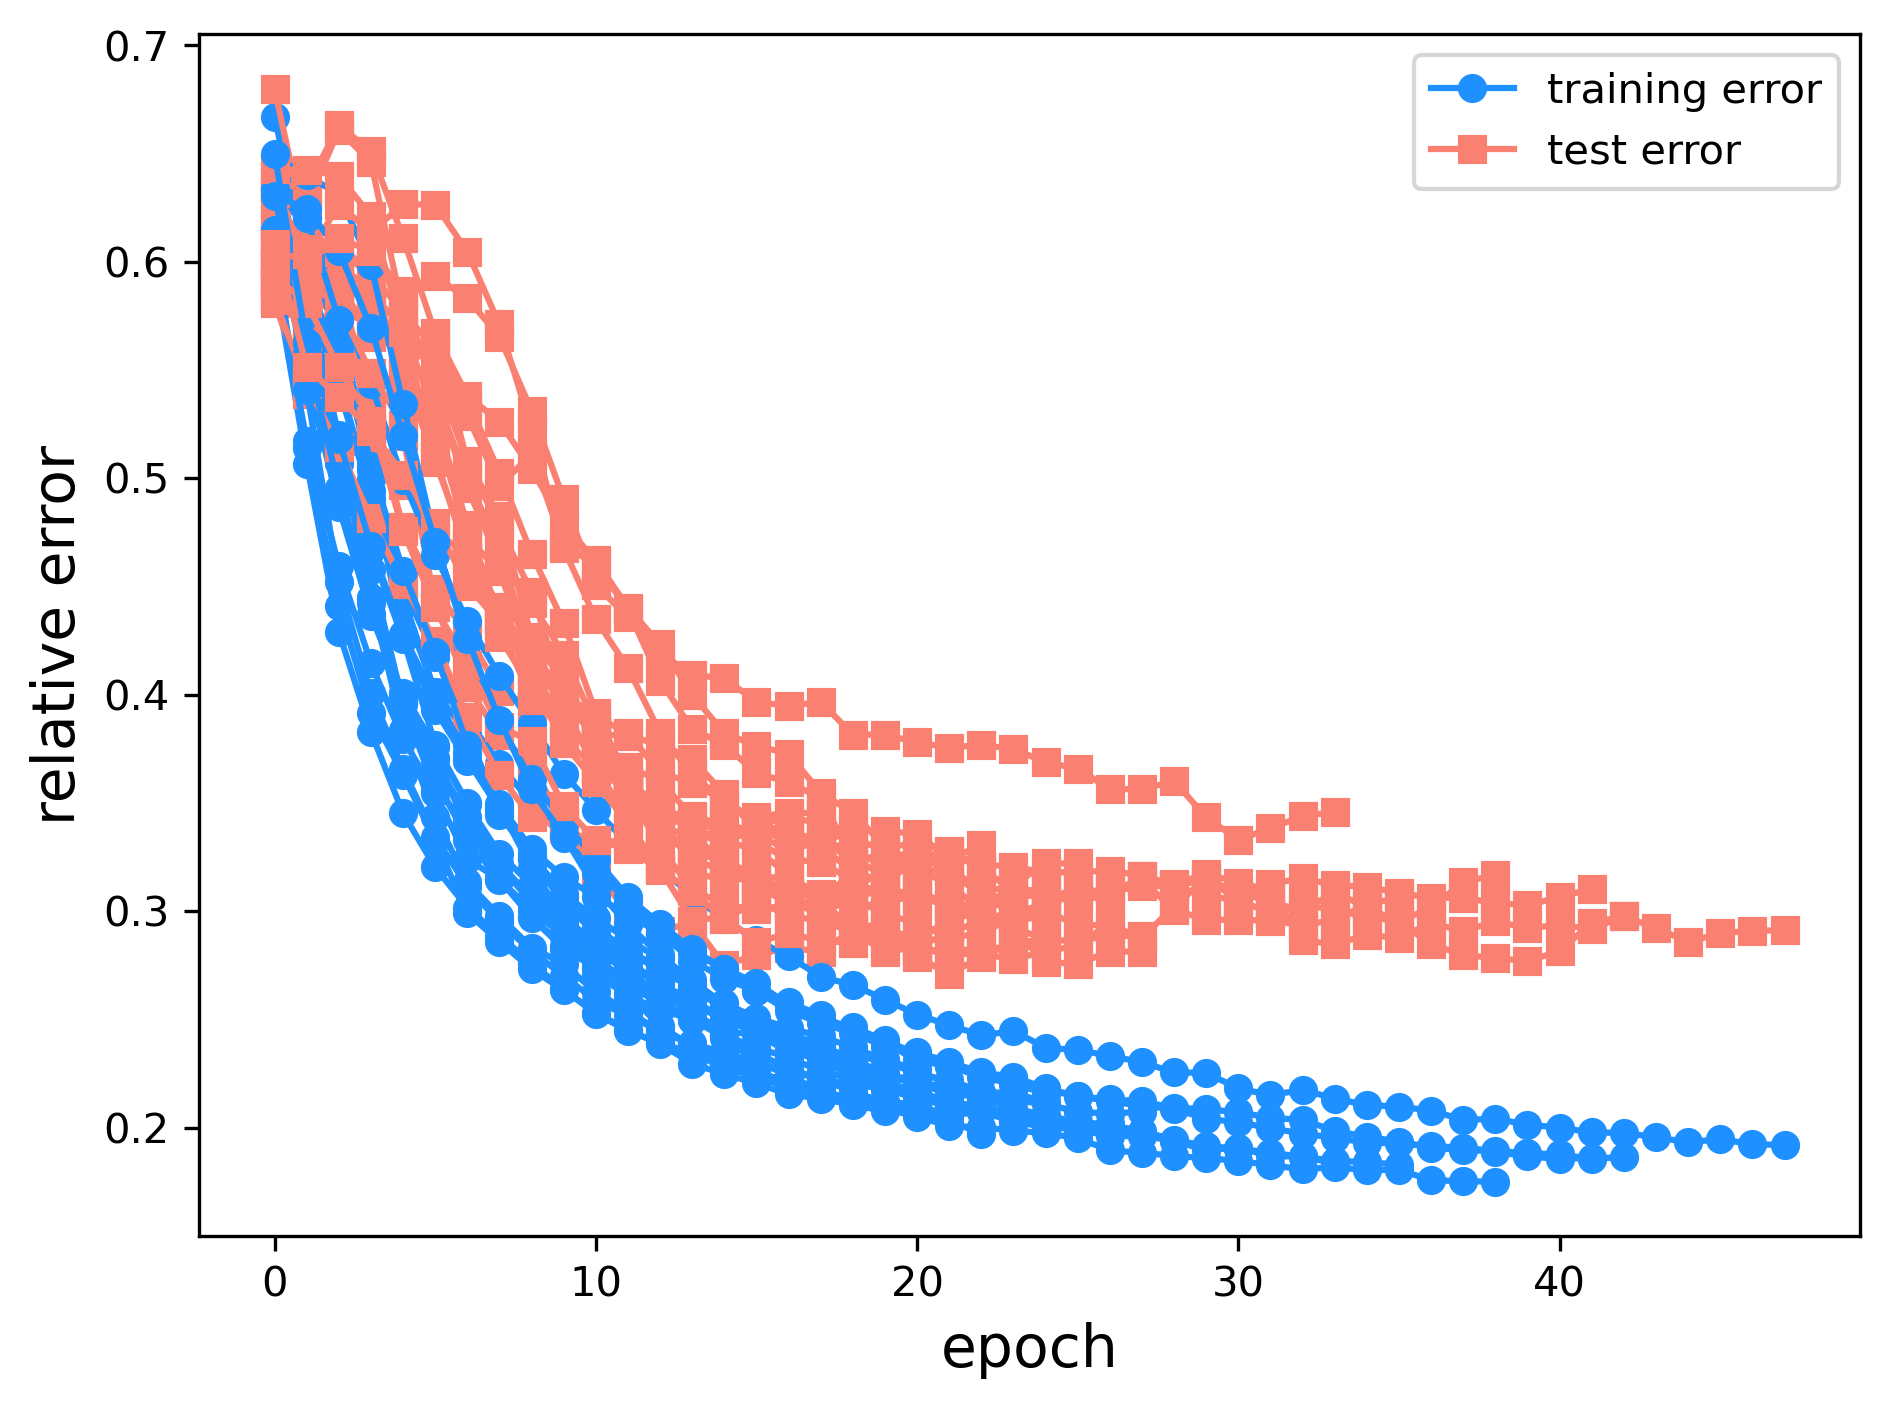

In [43]:
# plot the relative DAS training and test error for the last replica network
plot_errors(results_das)

### Get training results

In [44]:
# select the surrogate with the lowest test error
epoch_stop = results_das['epoch_stop']
test_errors = np.array(results_das['errors'])[:, :, 1]
test_errors = [error[epoch_stop[idx]] for idx, error in enumerate(test_errors)]
best_idx = np.argmin(test_errors)
das_surrogate = results_das['surrogate'][best_idx]

# compute the active subspace on the training and test data
W_1 = results_das['projection_matrix'][best_idx]
y_das_train = np.dot(W_1.T, params_train.T).T
y_das_test = np.dot(W_1.T, params_test.T).T

### Recreate the eigenvalue plots

Plot the eigenvalues with confidence intervals. 

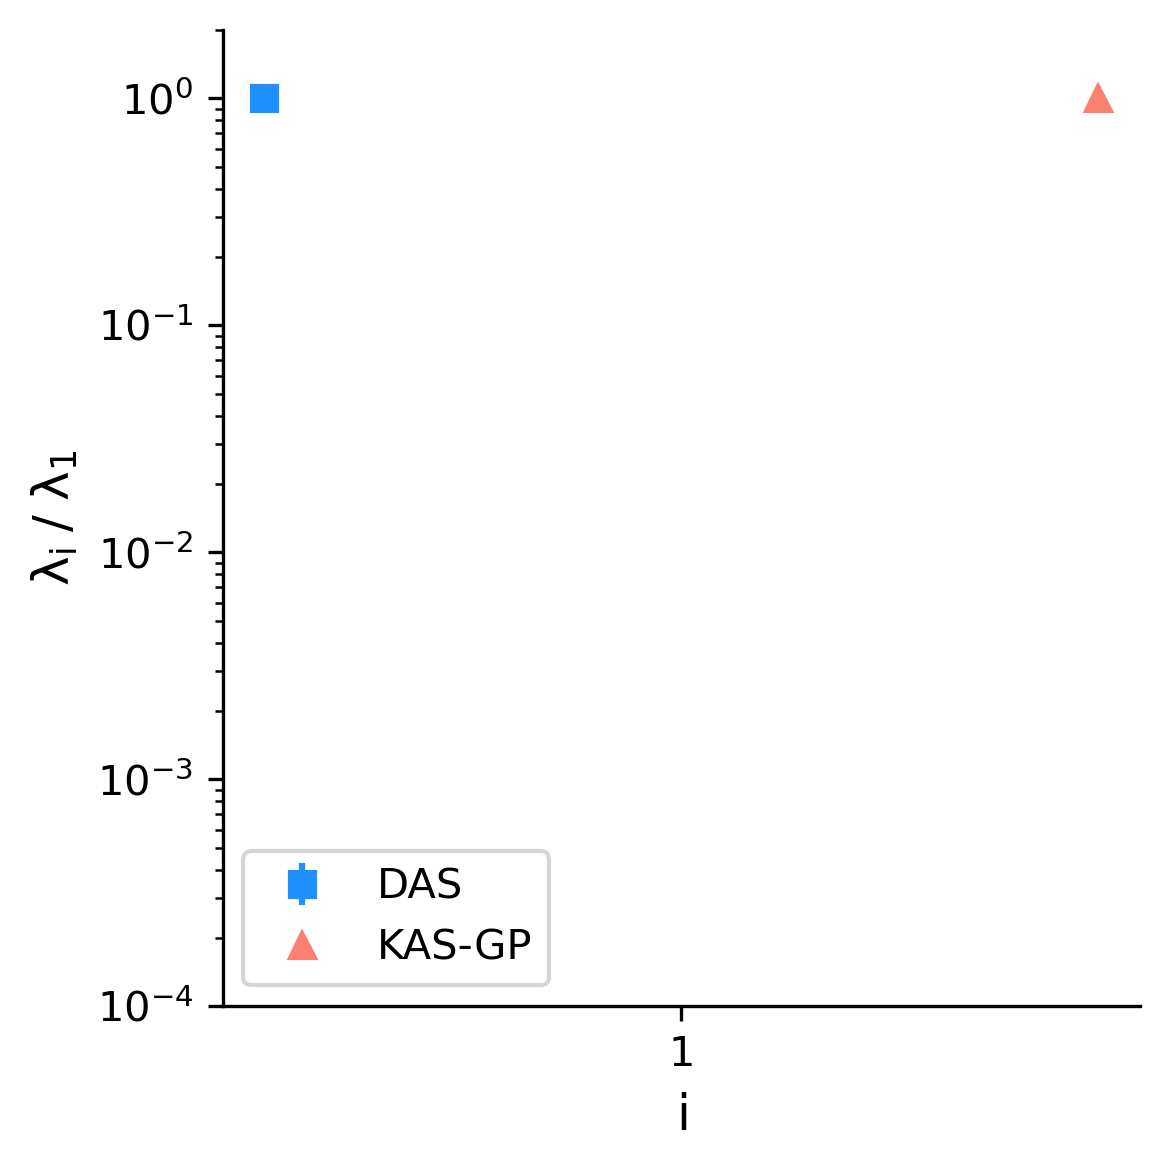

In [45]:
# number of eigenvalues to plot
n_vals = d

# basic analysisclass to compute the confidence intervals
analysis = es.analysis.BaseAnalysis()

# DAS eigenvalues
eigvals_C_das = results_das['eigvals'] 
eigvals_C_das = eigvals_C_das / np.mean(eigvals_C_das, axis=0)[0]
# eigenvalues averaged over the n_rep replica networks
mean_eigval_das = np.mean(eigvals_C_das[:, 0:n_vals], axis=0)
# compute confidence intervals
lower, upper = analysis.get_confidence_intervals(eigvals_C_das[:, 0:n_vals])
y_err_das = np.array([mean_eigval_das - lower, upper - mean_eigval_das])

# Load GP results from file
GP_eigvals = pd.read_csv('./GP_eigvals/scaled_eigen_results_ties.csv')
GP_mean = GP_eigvals['Eigenval_mean'].values
GP_std = GP_eigvals['Eigenval_std'].values

# plot results.
fig = plt.figure(figsize=[4, 4])
ax1 = fig.add_subplot(111, yscale='log', ylim=[1e-4, 2])
ax1.set_ylabel(r'$\lambda_i\;/\;\lambda_1$', fontsize=12)
ax1.set_xlabel(r'$i$', fontsize=12)
offset = 0.1
ax1.errorbar(np.arange(1, n_vals + 1)-offset, mean_eigval_das, 
             yerr = y_err_das, fmt='s', color='dodgerblue', label='DAS')
ax1.errorbar(np.arange(1, n_vals + 1)+offset, GP_mean[0:n_vals], 
             fmt='^', color='salmon', label='KAS-GP')#, yerr = GP_std[0:n_vals])
plt.legend(loc=0)
ax1.set_xticks(np.arange(1, n_vals + 1, 1))
sns.despine(top=True)
plt.tight_layout()

fig.savefig('./images/ties_eigvals_d%d.png' % (d,))

### Recreate the active subspace plot

Plot the predictions in a 1D active subspace.

In [46]:
# run the DAS surrogate a a number of random inputs locations
n_mc = 1000
pred_inputs = np.random.rand(n_mc, D) * 2 - 1
das_samples_pred = np.zeros(n_mc)
for i in range(n_mc):
    das_samples_pred[i] = das_surrogate.predict(pred_inputs[i])


In [47]:
# active subspace at prediction inputs x
y_val_das = np.dot(W_1.T, pred_inputs.T).T
idx = np.argsort(y_val_das.flatten())

### Recreate the active subspace plot

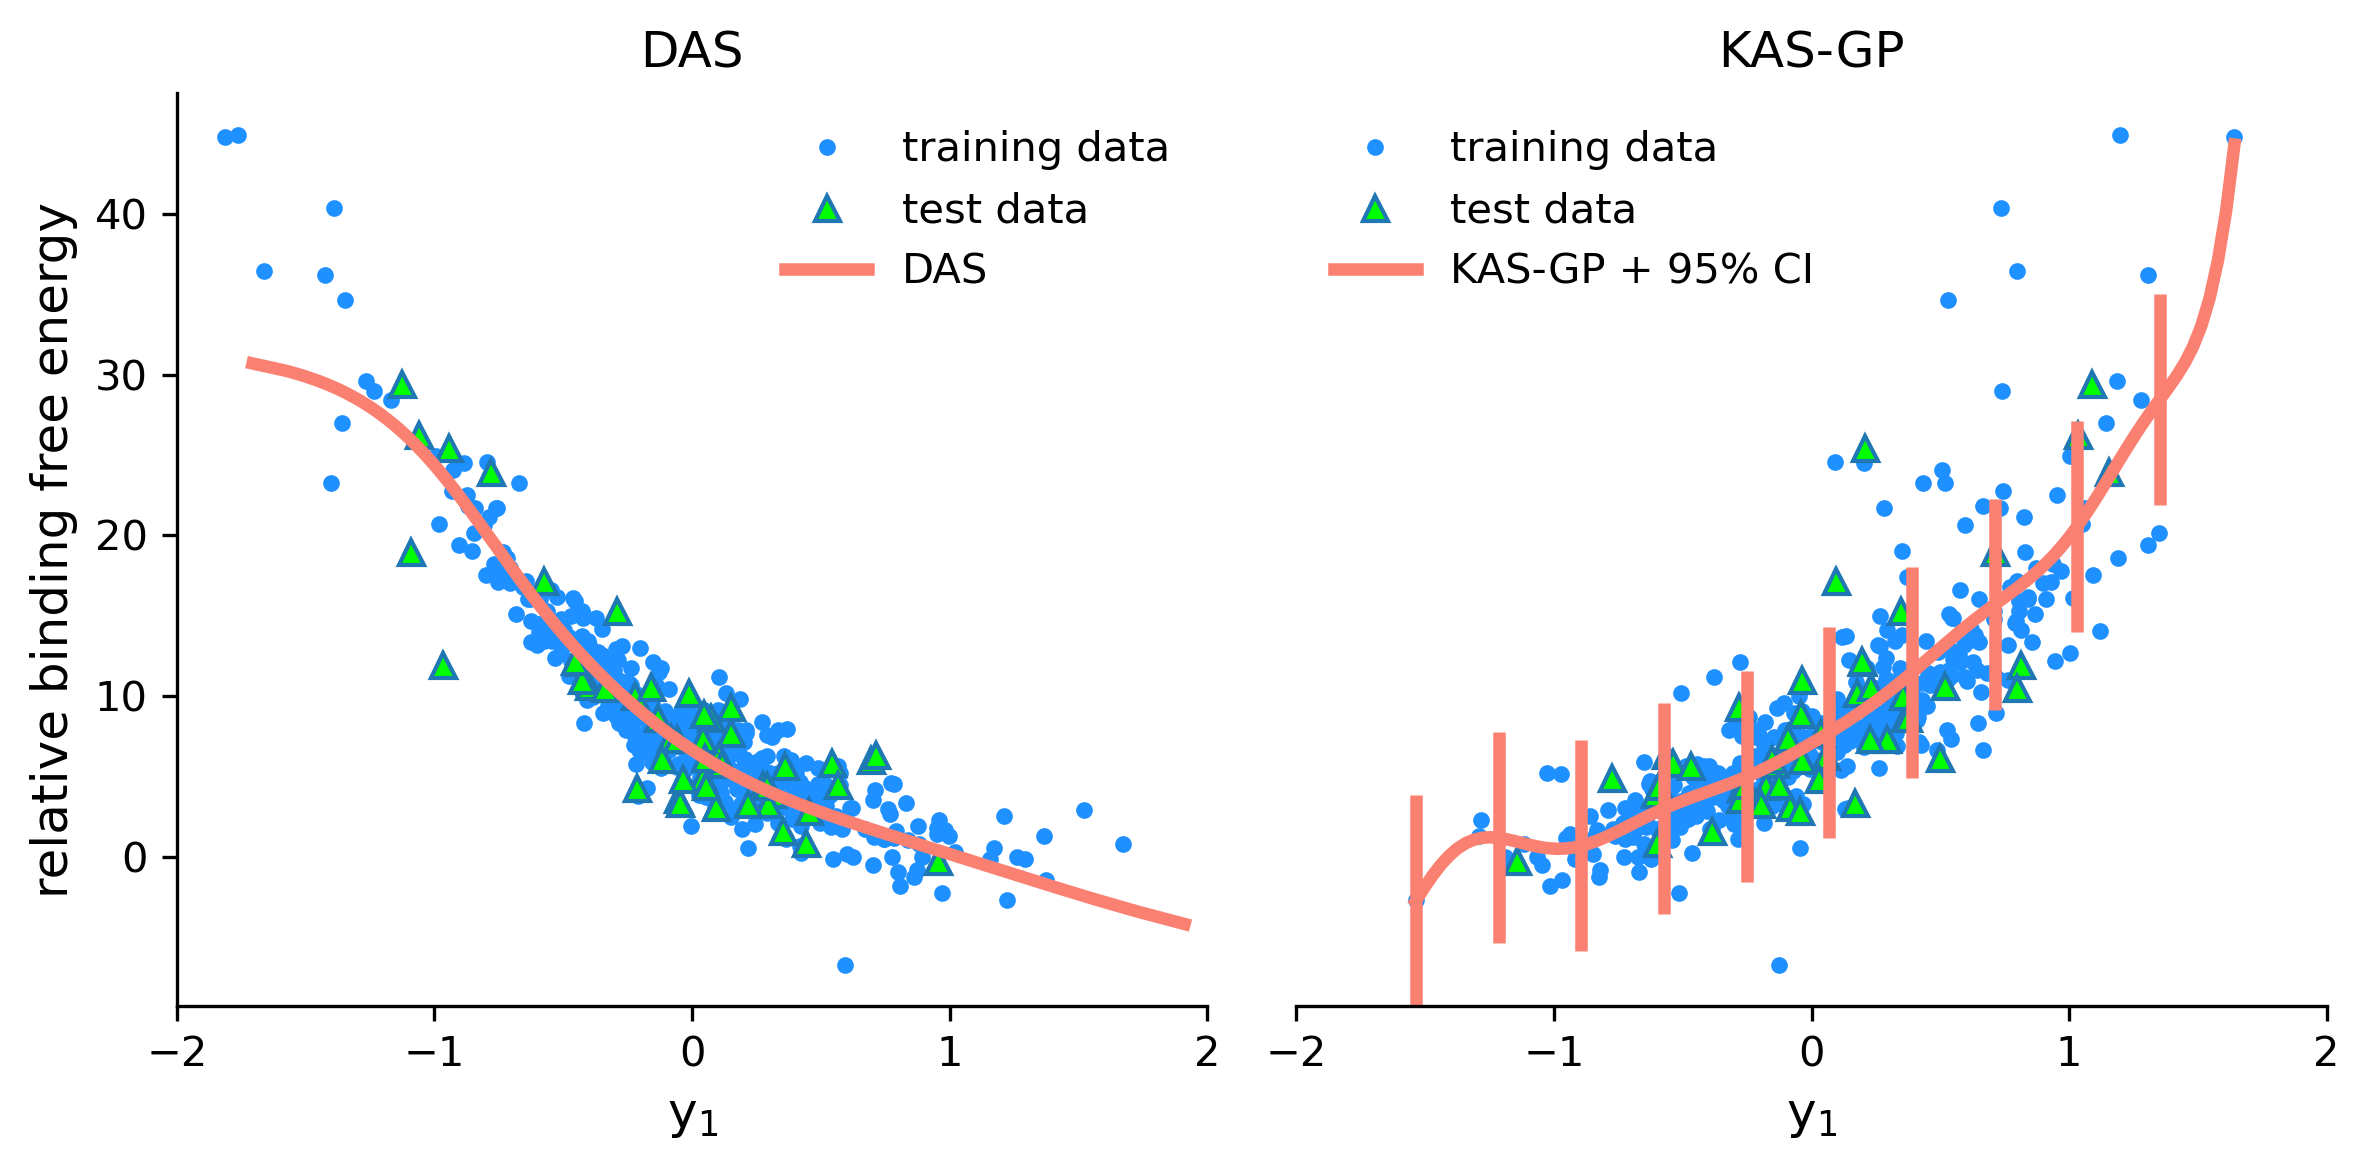

In [48]:
# QoI labels
lbl = {QoI: r'relative binding free energy'}

#########################
# plot active subspaces #
#########################
# plot DAS surrogate
fig = plt.figure(figsize=(8,4))
spec = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[1, 1])

ax = fig.add_subplot(spec[0],  xlim=[-2,2], title='DAS')    
ax.set_xlabel(r'$y_1$', fontsize=12)
ax.set_xticks([-2, -1, 0, 1, 2])
ax.set_ylabel(lbl[QoI], fontsize=12)
ax.plot(y_das_train[:,0], samples_train, '.', color='dodgerblue', label='training data') 
ax.plot(y_das_test[:,0], samples_test, '^', markerfacecolor='lime', label='test data') 
ax.plot(y_val_das[idx,0], das_samples_pred[idx], color='salmon', label='DAS', linewidth=3)
leg = ax.legend(loc=0, frameon=False)

ax2 = fig.add_subplot(spec[1], sharex = ax, ylim = ax.get_ylim(), title='KAS-GP') 
ax2.set_xlabel(r'$y_1$', fontsize=12)

# also plot GP surrogate from file
y_mean = das_surrogate.neural_net.y_mean
y_std = das_surrogate.neural_net.y_std
GP_surrogate = np.load('./GP_surrogate/ties_result.npy', allow_pickle=True).item()
ax2.plot(GP_surrogate['reduced_train_params'], samples_train, '.', color='dodgerblue', label='training data')
ax2.plot(GP_surrogate['reduced_test_params'], samples_test, '^', markerfacecolor='lime', label='test data')
ax2.plot(GP_surrogate['active_subspace'], GP_surrogate['prediction_mean'] * y_std + y_mean, color='salmon',
        label='KAS-GP + 95% CI', linewidth=3)
skip=10
ax2.errorbar(GP_surrogate['active_subspace'][0:-1:skip].flatten(), 
             GP_surrogate['prediction_mean'][0:-1:skip].flatten() * y_std + y_mean,
             yerr = GP_surrogate['prediction_CI'][0:-1:skip].flatten() * y_std, color='salmon',
             linewidth=0, elinewidth=3)
leg = ax2.legend(loc=0, frameon=False)

sns.despine(top=True, ax=ax)
sns.despine(top=True, ax=ax2)
sns.despine(left=True, ax=ax2)
ax2.set_yticks([])

plt.tight_layout()
plt.savefig('./images/ties_surrogate_d%d.png' % (d, ))


### Recreate the global-derivative based sensitivity plots

In [49]:
GP_results = pd.read_csv('./GP_SA/sensitivity_indices_ties.csv')

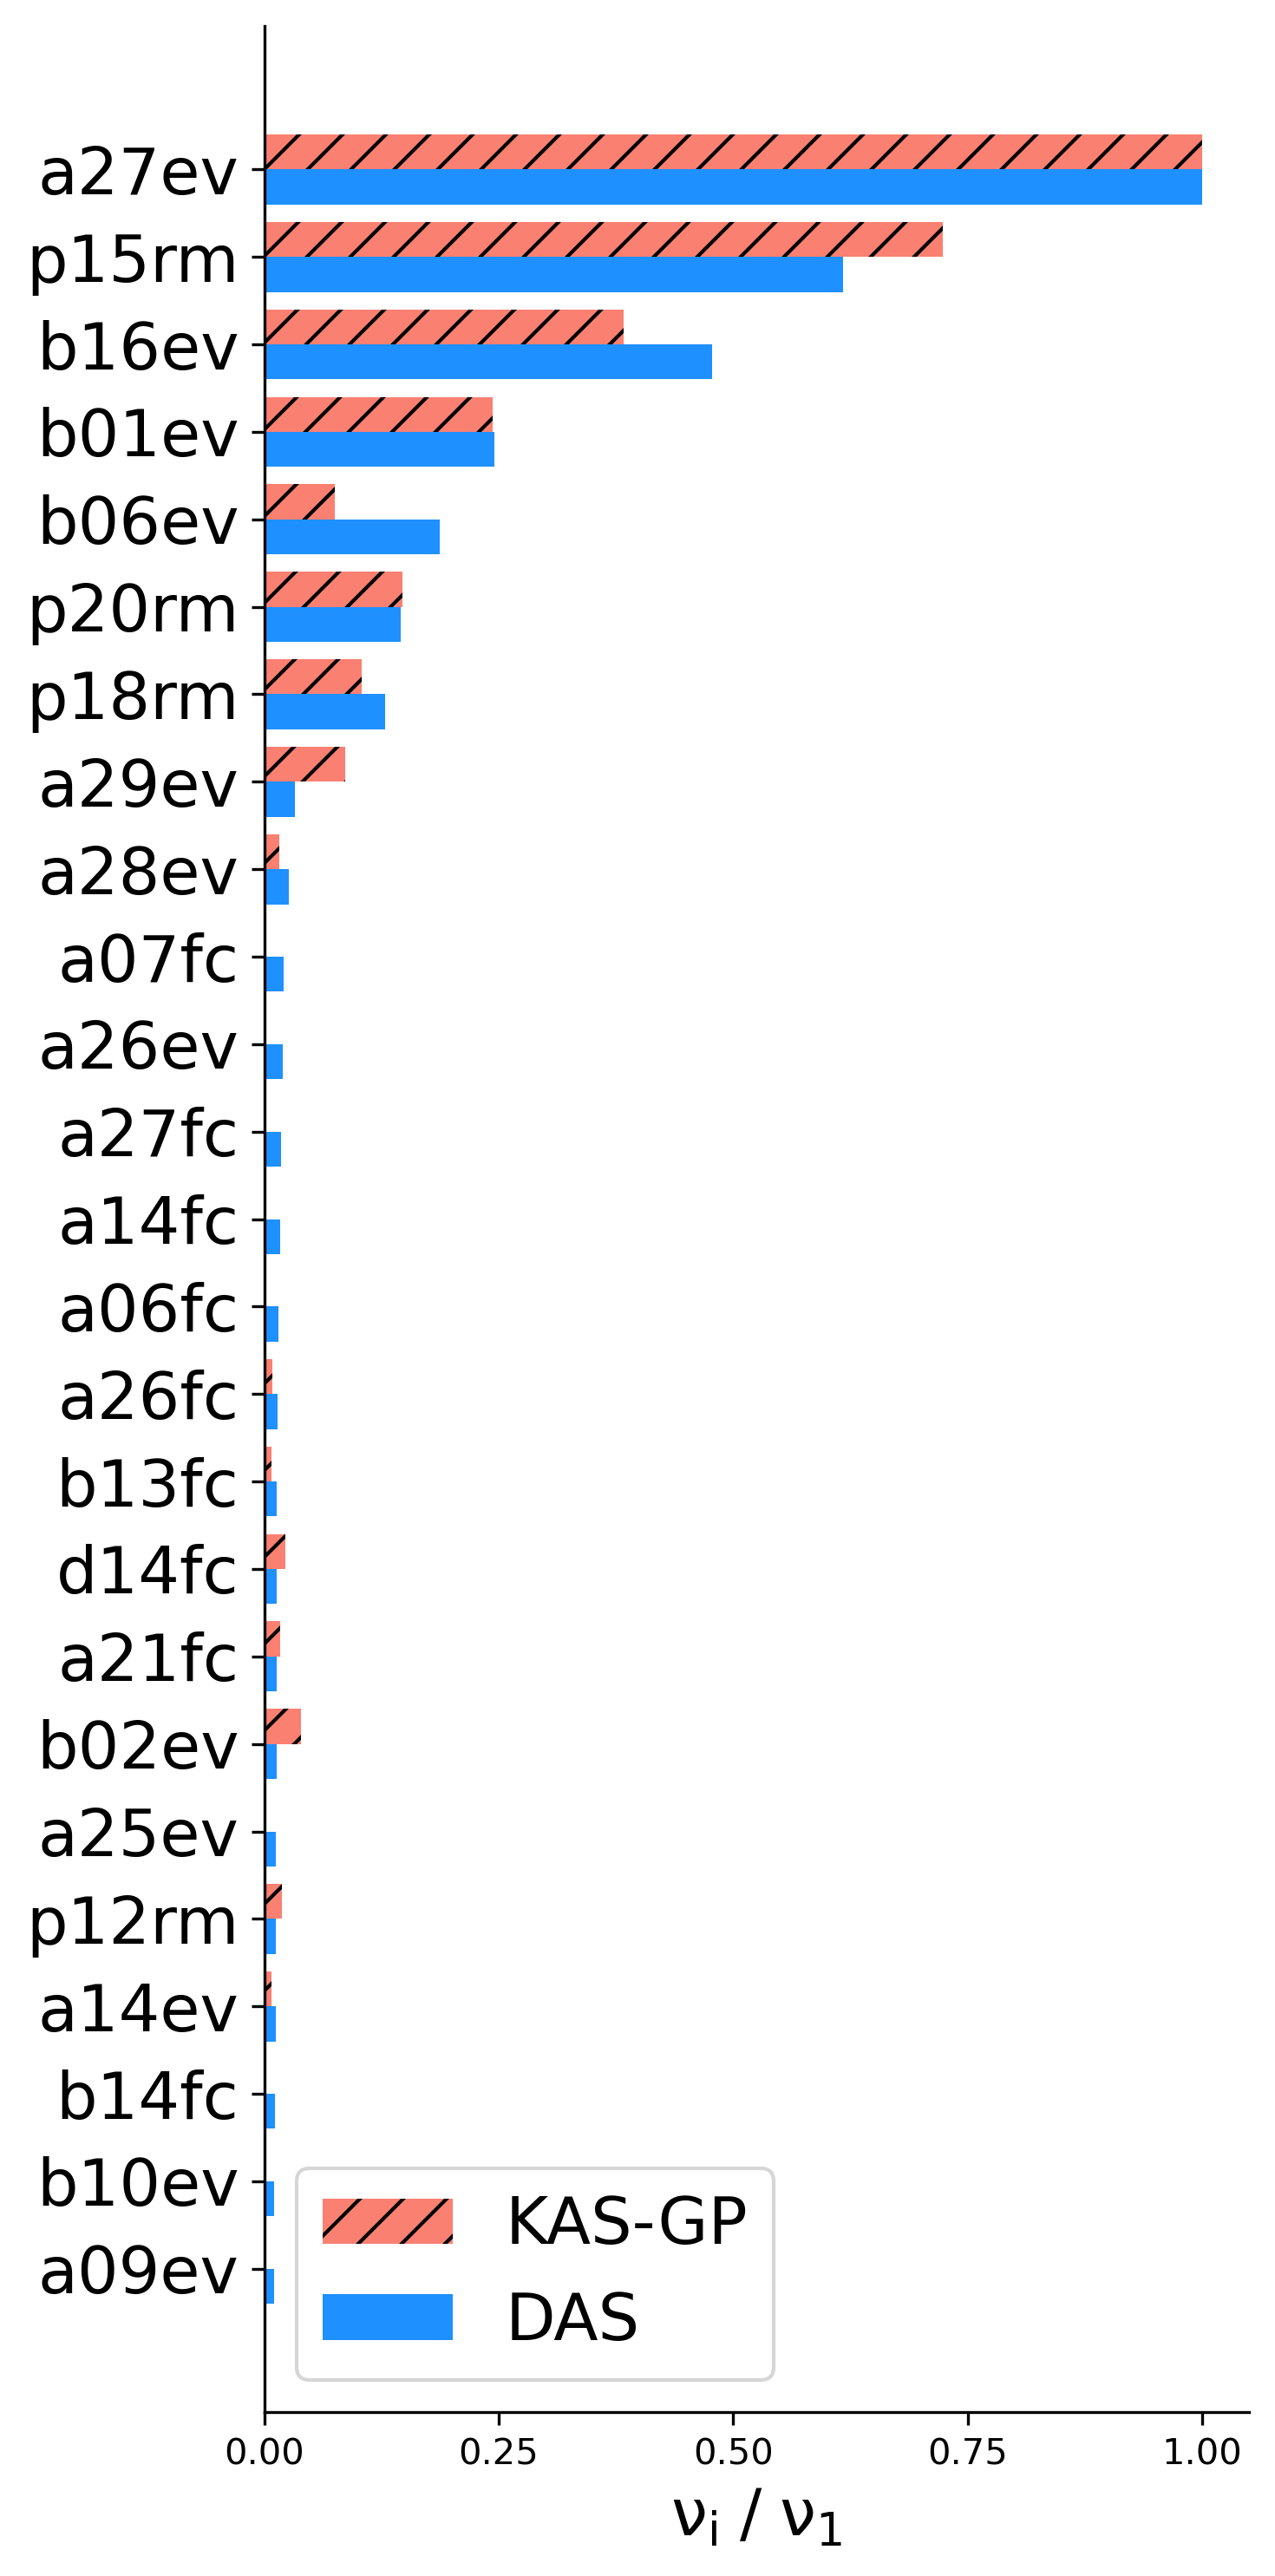

In [50]:
# plot sensitivity indices with CIs
plot_sensitivity(results_das, param_names, bar2 = GP_results)

### Compare epistemic with aleatoric uncertainty

Computing kernel-density estimate
done
Computing kernel-density estimate
done
Computing kernel-density estimate
done


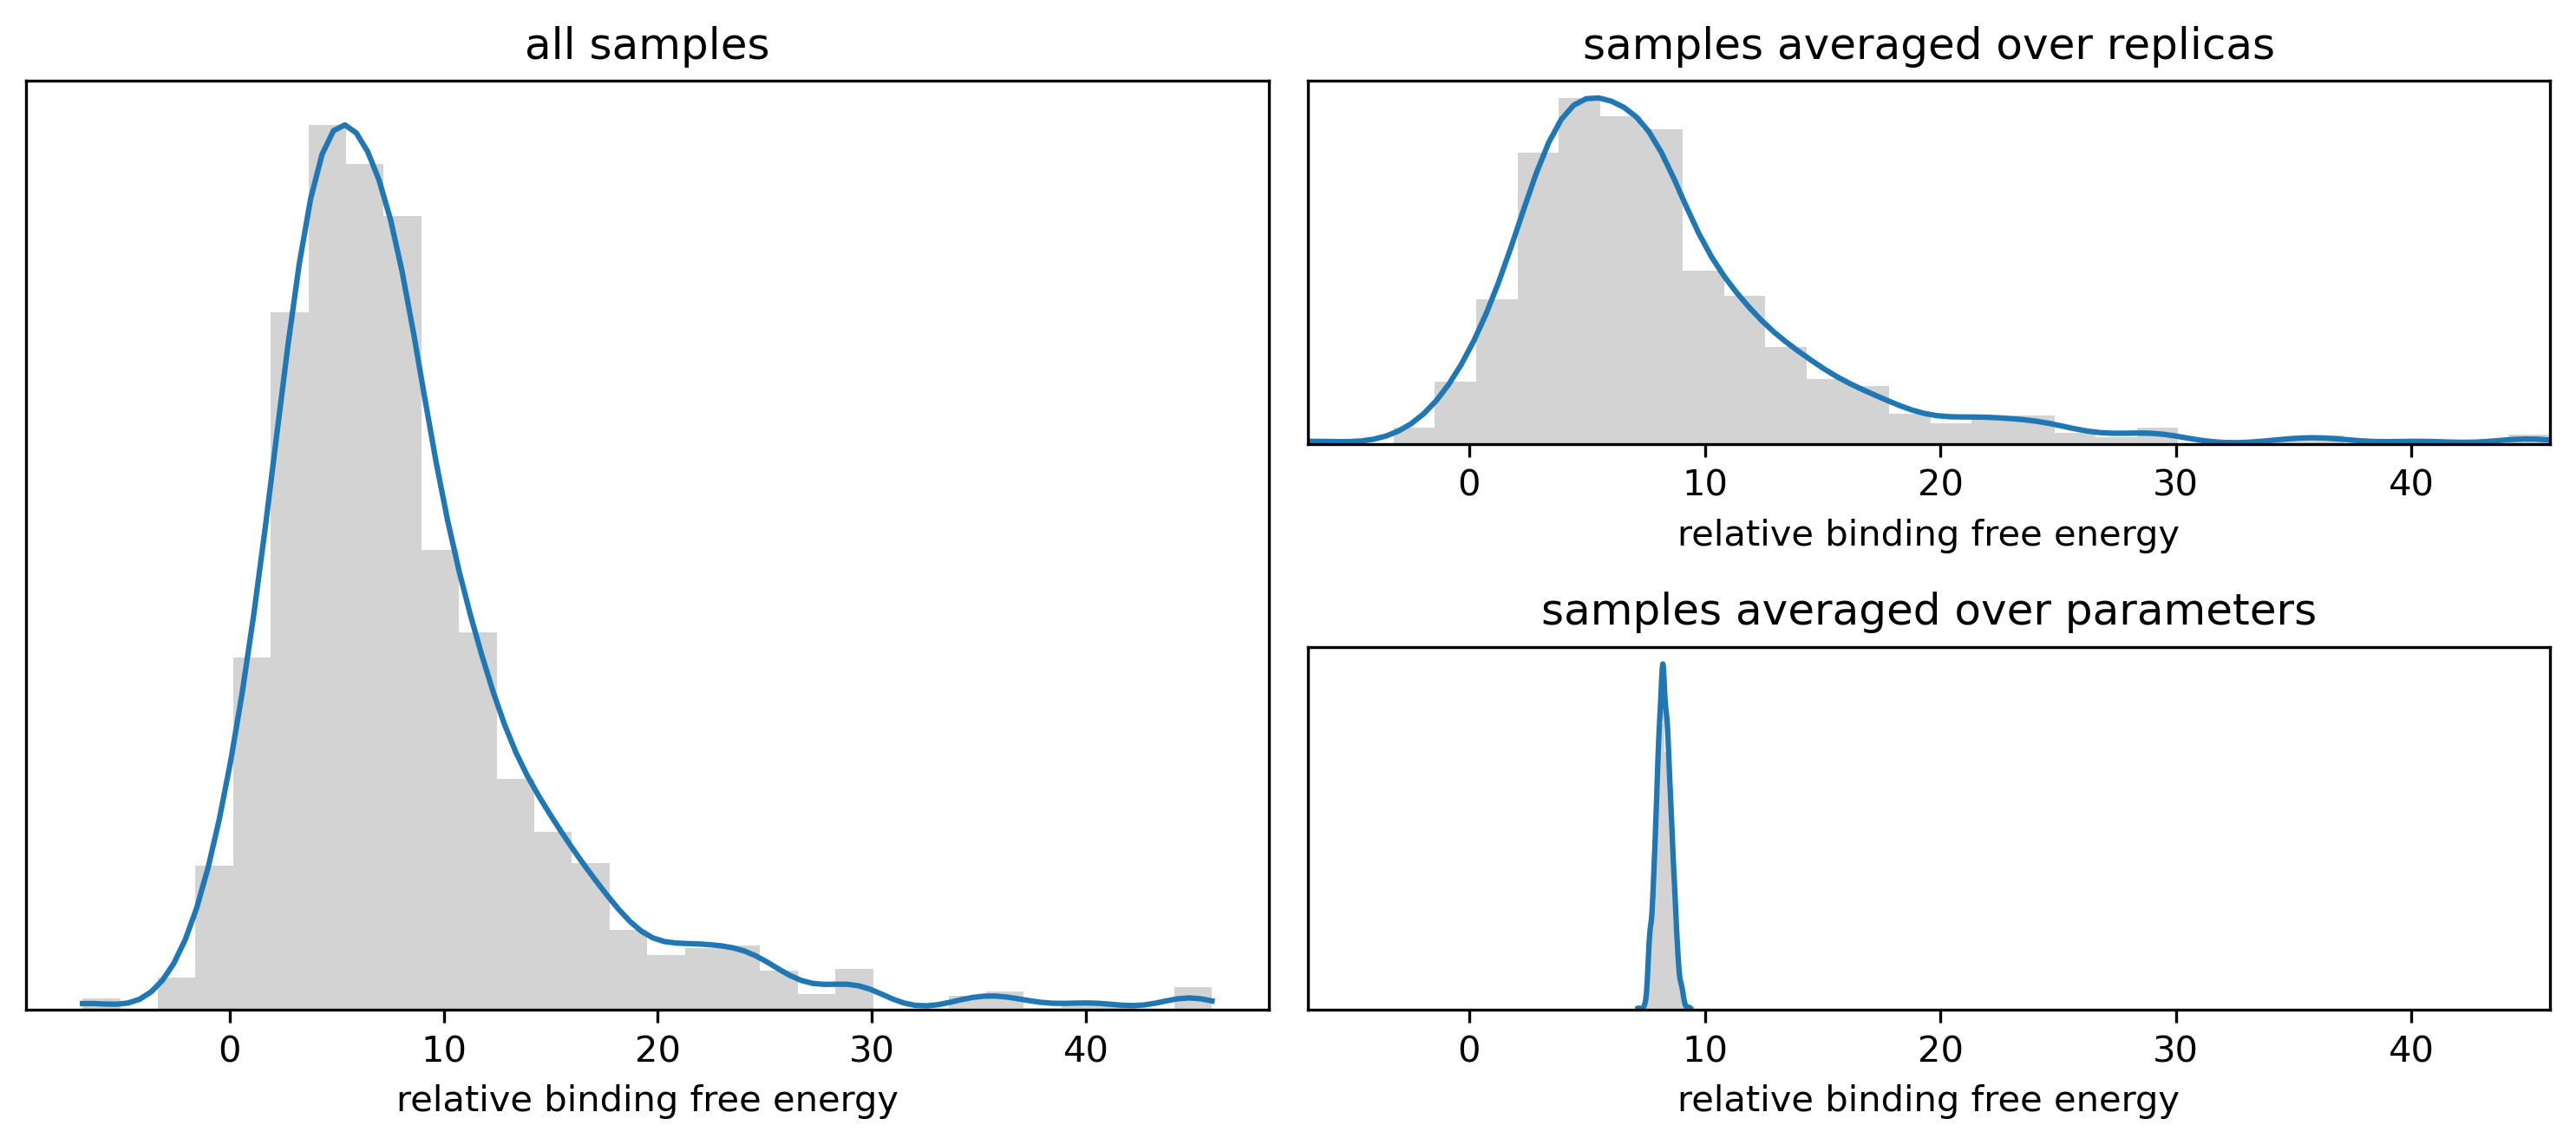

In [51]:
plot_dist(output, 'relative binding free energy')

### (Non-Gaussian) stats with bootstrapping

In [52]:
n_bootstap = 10 ** 5
n_samples = output.size

mean = np.zeros(n_bootstap)
std = np.zeros(n_bootstap)
skew = np.zeros(n_bootstap)
kurt = np.zeros(n_bootstap)

output = output.flatten() 

for i in tqdm(range(n_bootstap)):
    # resample with replacement
    idx = np.random.randint(0, n_samples, n_samples)
    # recompute moments
    mean[i] = np.mean(output[idx])
    std[i] = np.std(output[idx])
    skew[i] = stats.skew(output[idx])
    kurt[i] = stats.kurtosis(output[idx])

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100000/100000 [02:27<00:00, 678.73it/s]


In [53]:
lower_mean, upper_mean = analysis.get_confidence_intervals(mean.reshape([-1,1]))
lower_std, upper_std = analysis.get_confidence_intervals(std.reshape([-1,1]))
lower_skew, upper_skew = analysis.get_confidence_intervals(skew.reshape([-1,1]))
lower_kurt, upper_kurt = analysis.get_confidence_intervals(kurt.reshape([-1,1]))

In [54]:
print("Mean: %.2f (%.2f/%.2f)" % (np.mean(output), lower_mean, upper_mean))
print("Std dev: %.2f (%.2f/%.2f)" % (np.std(output), lower_std, upper_std))
print("Skew: %.2f (%.2f/%.2f)" % (stats.skew(output), lower_skew, upper_skew))
print("Kurt: %.2f (%.2f/%.2f)" % (stats.kurtosis(output), lower_kurt, upper_kurt))
print("N_samples = %d" % n_samples)

Mean: 8.23 (8.00/8.45)
Std dev: 6.70 (6.38/7.01)
Skew: 1.95 (1.77/2.11)
Kurt: 5.94 (4.90/6.88)
N_samples = 2440
